# Imports

In [ ]:
# Install if necessary
%pip install numpy
%pip install matplotlib
%pip install scikit-image
%pip install scikit-learn
%pip install Pillow
%pip install kagglehub
%pip install seaborn
%pip install pandas
%pip install kaggle
%pip install tensorflow
%pip install torch
%pip install torchvision

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.feature import hog
from sklearn.feature_selection import VarianceThreshold
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import kagglehub
from skimage import exposure
from torchvision import transforms, datasets
from cifar10_models.resnet import resnet18  # Make sure the folder structure is as intended... :)
import os
from PIL import Image
from sklearn.feature_selection import SelectPercentile
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Fashion_MNIST

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


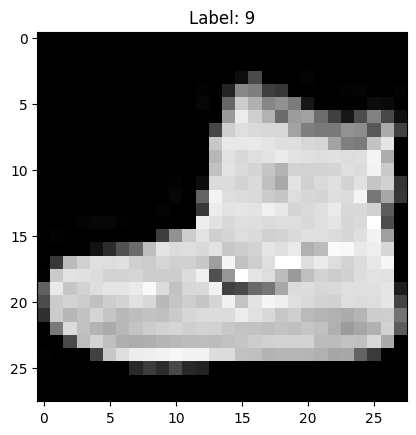

Image size: (28, 28)


In [ ]:
# Loading the Fashion-MNIST dataset
def load_fashion_mnist():
    # Using keras
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

    # Normalizing the images
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_fashion_mnist()

plt.imshow(x_train[0], cmap='gray')
plt.title(f'Label: {y_train[0]}')
plt.show()
print(f"Image size: {x_train[0].shape}")

# Extract PCA Fashion MNIST

In [ ]:
# Extracting PCA features for the Fashion-MNIST dataset
def extract_pca_features(train, test, n_components=17):
    pca = PCA(n_components=n_components)
    pca_train_features = pca.fit_transform(train.reshape(train.shape[0], -1))
    pca_test_features = pca.transform(test.reshape(test.shape[0], -1))

    return pca_train_features, pca_test_features


pca_train_features, pca_test_features = extract_pca_features(x_train, x_test)

print(f"PCA Train Features Shape: {pca_train_features.shape}")
print(f"PCA Test Features Shape: {pca_test_features.shape}")

PCA Train Features Shape: (60000, 17)
PCA Test Features Shape: (10000, 17)


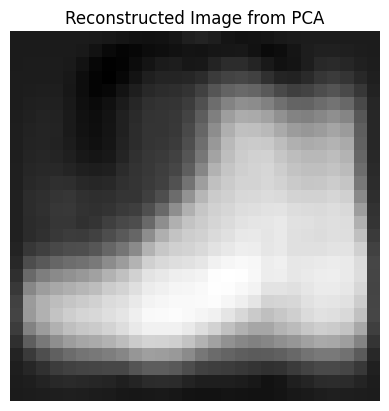

In [ ]:
# Test for reconstruction
pca = PCA(n_components=17)
pca.fit(x_train.reshape(len(x_train), -1))  # Flattening

# Reconstructing the first image
first_image_pca = pca_train_features[0].reshape(1, -1)
reconstructed_image = pca.inverse_transform(first_image_pca)

# Reshaping
reconstructed_image = reconstructed_image.reshape(28, 28)

plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image from PCA')
plt.axis('off')
plt.show()


# Extract HOG Fashion_MNIST

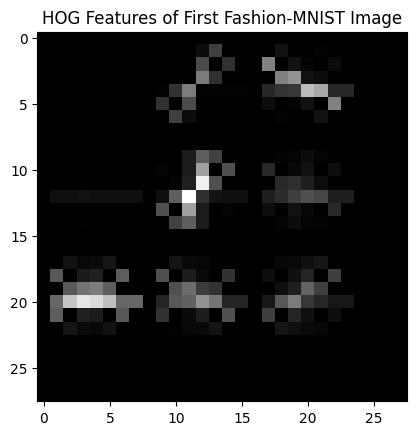

HOG Train Features Shape: (60000, 144)
HOG Test Features Shape: (10000, 144)


In [ ]:
# Extracting HOG features for Fashion-MNIST
def extract_hog_features(image, cells_per_block=(2, 2), visualization=False):
    if visualization:
        fd, hog_image = hog(image,
                            cells_per_block=cells_per_block, visualize=True)

        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        return fd, hog_image_rescaled
    else:
        fd = hog(image, cells_per_block=cells_per_block)
        return fd, None


fd, hog_image_rescaled = extract_hog_features(x_train[0], visualization=True)
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
plt.title('HOG Features of First Fashion-MNIST Image')
plt.show()

hog_train_features = np.array([extract_hog_features(img)[0] for img in x_train])
hog_test_features = np.array([extract_hog_features(img)[0] for img in x_test])

print(f"HOG Train Features Shape: {hog_train_features.shape}")
print(f"HOG Test Features Shape: {hog_test_features.shape}")

# Combine Fashion_MNIST

In [ ]:
# Combining PCA and HOG features for Fashion MNIST
def combine_pca_hog_features(pca_features, hog_features):
    return np.hstack((pca_features, hog_features))

combined_train_features_fashion = combine_pca_hog_features(pca_train_features, hog_train_features)
combined_test_features_fashion = combine_pca_hog_features(pca_test_features, hog_test_features)

print(f"Combined Train Features Shape (Fashion MNIST): {combined_train_features_fashion.shape}")
print(f"Combined Test Features Shape (Fashion MNIST): {combined_test_features_fashion.shape}")

Combined Train Features Shape (Fashion MNIST): (60000, 161)
Combined Test Features Shape (Fashion MNIST): (10000, 161)


# Load Fruits-360

Path to dataset files: /root/.cache/kagglehub/datasets/moltean/fruits/versions/11
Training images shape: (70491, 28, 28, 3)
Testing images shape: (23619, 28, 28, 3)


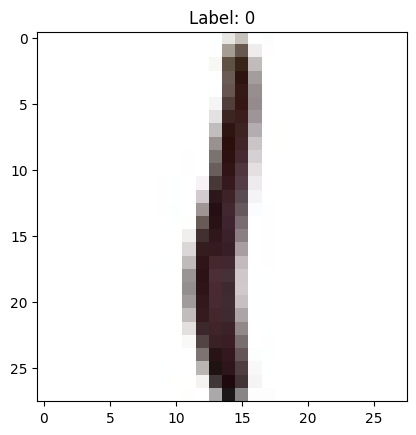

In [9]:
# Downloading the dataset using kagglehub
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

# Defining the full paths for Training and Testing directories
train_dir = os.path.join(path, 'fruits-360_dataset_100x100/fruits-360/Training')
test_dir = os.path.join(path, 'fruits-360_dataset_100x100/fruits-360/Test')

def load_fruits_from_directory(directory, image_size=(28, 28)):
    images = []
    labels = []
    label_map = {}
    label = 0

    for fruit in os.listdir(directory):
        fruit_path = os.path.join(directory, fruit)
        if os.path.isdir(fruit_path):
            label_map[label] = fruit
            for image_file in os.listdir(fruit_path):
                image_path = os.path.join(fruit_path, image_file)
                image = Image.open(image_path)
                image = image.resize(image_size)
                image = np.array(image)

                images.append(image)
                labels.append(label)
            label += 1

    images = np.array(images)
    labels = np.array(labels)
    return images, labels, label_map

x_train_fruits, y_train_fruits, label_map_train = load_fruits_from_directory(train_dir)
x_test_fruits, y_test_fruits, label_map_test = load_fruits_from_directory(test_dir)

print(f"Training images shape: {x_train_fruits.shape}")
print(f"Testing images shape: {x_test_fruits.shape}")

plt.imshow(x_train_fruits[100], cmap='gray')
plt.title(f'Label: {y_train_fruits[100]}')
plt.show()

# Extract PCA Fruits-360

In [ ]:
# Extracting PCA features for Fruits-360
def extract_pca_features(train, test, n_components=17):
    pca = PCA(n_components=n_components)
    pca_train_features = pca.fit_transform(train.reshape(train.shape[0], -1))
    pca_test_features = pca.transform(test.reshape(test.shape[0], -1))

    return pca_train_features, pca_test_features

pca_train_features_fruits, pca_test_features_fruits = extract_pca_features(x_train_fruits, x_test_fruits)

print(f"PCA Train Features (Fruits-360) Shape: {pca_train_features_fruits.shape}")
print(f"PCA Test Features (Fruits-360) Shape: {pca_test_features_fruits.shape}")

PCA Train Features (Fruits-360) Shape: (70491, 17)
PCA Test Features (Fruits-360) Shape: (23619, 17)


# Extract HOG Fruits-360

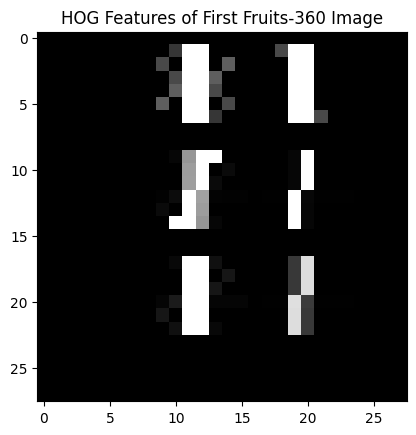

HOG Train Features (Fruits-360) Shape: (70491, 144)
HOG Test Features (Fruits-360) Shape: (23619, 144)


In [ ]:
# Extracting HOG features for Fruits-360
def extract_hog_features_fruits(image, cells_per_block=(2, 2), visualization=False):
    if visualization:
        fd, hog_image = hog(image,
                            cells_per_block=cells_per_block, visualize=True, channel_axis=-1)

        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        return fd, hog_image_rescaled
    else:
        fd = hog(image, cells_per_block=cells_per_block, channel_axis=-1)
        return fd, None

fd, hog_image_rescaled_fruits = extract_hog_features_fruits(x_train_fruits[100], visualization=True)
plt.imshow(hog_image_rescaled_fruits, cmap=plt.cm.gray)
plt.title('HOG Features of First Fruits-360 Image')
plt.show()

hog_train_features_fruits = np.array([extract_hog_features_fruits(img)[0] for img in x_train_fruits])
hog_test_features_fruits = np.array([extract_hog_features_fruits(img)[0] for img in x_test_fruits])

print(f"HOG Train Features (Fruits-360) Shape: {hog_train_features_fruits.shape}")
print(f"HOG Test Features (Fruits-360) Shape: {hog_test_features_fruits.shape}")

# Combine Fruits-360

In [ ]:
# Combining PCA and HOG features for Fruits-360
def combine_pca_hog_features_fruits(pca_features, hog_features):
    return np.hstack((pca_features, hog_features))

combined_train_features_fruits = combine_pca_hog_features_fruits(pca_train_features_fruits, hog_train_features_fruits)
combined_test_features_fruits = combine_pca_hog_features_fruits(pca_test_features_fruits, hog_test_features_fruits)

print(f"Combined Train Features Shape (Fruits-360): {combined_train_features_fruits.shape}")
print(f"Combined Test Features Shape (Fruits-360): {combined_test_features_fruits.shape}")

Combined Train Features Shape (Fruits-360): (70491, 161)
Combined Test Features Shape (Fruits-360): (23619, 161)


# Standardization

In [ ]:
# Standardize the combined features for Fashion-MNIST
scaler = StandardScaler()
combined_train_features_scaled_fashion = scaler.fit_transform(combined_train_features_fashion)
combined_test_features_scaled_fashion = scaler.transform(combined_test_features_fashion)

# Standardize the combined features for Fruits-360
scaler_fruits = StandardScaler()
combined_train_features_scaled_fruits = scaler_fruits.fit_transform(combined_train_features_fruits)
combined_test_features_scaled_fruits = scaler_fruits.transform(combined_test_features_fruits)

# Feature selection

In [ ]:
# Applying Variance Thresholding to reduce the number of features
selector = SelectPercentile(percentile=40)
reduced_train_features_fashion = selector.fit_transform(combined_train_features_scaled_fashion, y_train)
reduced_test_features_fashion = selector.transform(combined_test_features_scaled_fashion)

print(f"Original Train Features Shape: {combined_train_features_scaled_fashion.shape}")
print(f"Reduced Train Features Shape: {reduced_train_features_fashion.shape}")

# Applying Variance Thresholding to reduce the number of features for Fruits-360
selector_fruits = SelectPercentile(percentile=80)
reduced_train_features_fruits = selector_fruits.fit_transform(combined_train_features_scaled_fruits, y_train_fruits)
reduced_test_features_fruits = selector_fruits.transform(combined_test_features_scaled_fruits)

# Print the shape of the reduced features
print(f"Original Train Features Shape: {combined_train_features_scaled_fruits.shape}")
print(f"Reduced Train Features Shape: {reduced_train_features_fruits.shape}")

Original Train Features Shape: (60000, 161)
Reduced Train Features Shape: (60000, 64)
Original Train Features Shape: (70491, 161)
Reduced Train Features Shape: (70491, 128)


# Models

## MLP with Features

### Fashion

In [ ]:
# Convert TensorFlow preprocessed data to PyTorch tensors
x_train_torch = torch.tensor(reduced_train_features_fashion, dtype=torch.float32)
x_test_torch = torch.tensor(reduced_test_features_fashion, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

# Split training data into training and validation sets
train_size = int(0.8 * len(x_train_torch))
val_size = len(x_train_torch) - train_size
train_dataset = TensorDataset(x_train_torch, y_train_torch)
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(x_test_torch, y_test_torch), batch_size=32, shuffle=False)

In [ ]:
# Define MLP for Fashion-MNIST
class MLPFashion(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLPFashion, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.model(x)

Epoch [1/20] Train Loss: 0.8418, Train Acc: 0.6838, Val Loss: 0.5682, Val Acc: 0.7772
Epoch [2/20] Train Loss: 0.6416, Train Acc: 0.7592, Val Loss: 0.5343, Val Acc: 0.7975
Epoch [3/20] Train Loss: 0.6074, Train Acc: 0.7726, Val Loss: 0.5221, Val Acc: 0.7988
Epoch [4/20] Train Loss: 0.5882, Train Acc: 0.7793, Val Loss: 0.5033, Val Acc: 0.8103
Epoch [5/20] Train Loss: 0.5734, Train Acc: 0.7853, Val Loss: 0.4932, Val Acc: 0.8138
Epoch [6/20] Train Loss: 0.5605, Train Acc: 0.7899, Val Loss: 0.4859, Val Acc: 0.8150
Epoch [7/20] Train Loss: 0.5511, Train Acc: 0.7941, Val Loss: 0.4796, Val Acc: 0.8204
Epoch [8/20] Train Loss: 0.5443, Train Acc: 0.7976, Val Loss: 0.4728, Val Acc: 0.8208
Epoch [9/20] Train Loss: 0.5417, Train Acc: 0.7981, Val Loss: 0.4737, Val Acc: 0.8217
Epoch [10/20] Train Loss: 0.5363, Train Acc: 0.8017, Val Loss: 0.4788, Val Acc: 0.8196
Epoch [11/20] Train Loss: 0.5327, Train Acc: 0.8020, Val Loss: 0.4724, Val Acc: 0.8252
Epoch [12/20] Train Loss: 0.5286, Train Acc: 0.8001,

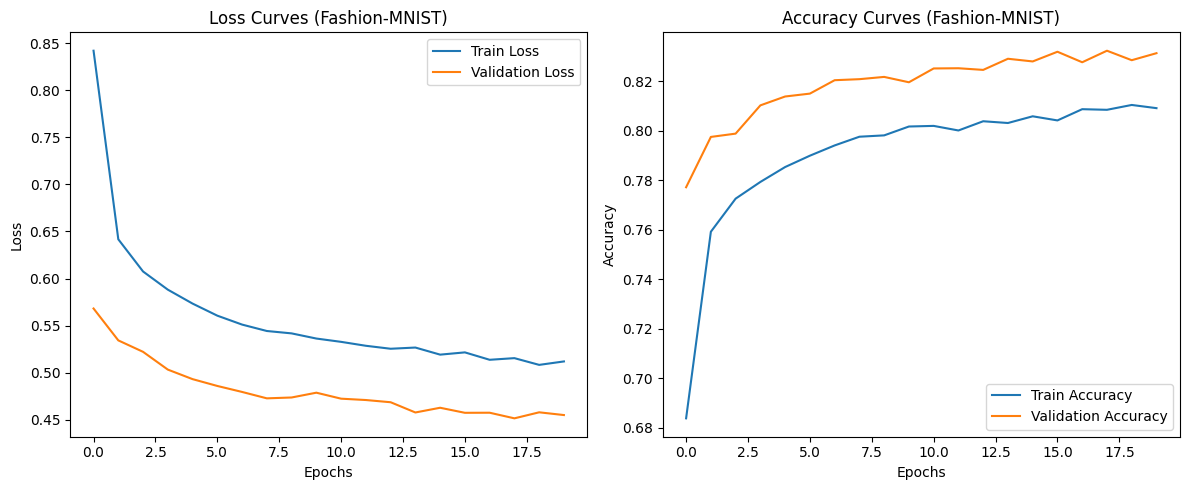

In [ ]:
# Instantiate model, define loss and optimizer
mlp_fashion = MLPFashion(x_train_torch.shape[1], 10).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_fashion.parameters(), lr=0.001)

# Training and validation functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(loader)
    train_acc = correct / total
    return train_loss, train_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss = running_loss / len(loader)
    val_acc = correct / total
    return val_loss, val_acc

# Train the model
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_fashion.to(device)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(mlp_fashion, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(mlp_fashion, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Evaluate on test set
test_loss, test_acc = validate_epoch(mlp_fashion, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves (Fashion-MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy Curves (Fashion-MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Classification Report (MLP):
              precision    recall  f1-score   support

 T-shirt/top       0.75      0.85      0.80      1000
     Trouser       0.96      0.94      0.95      1000
    Pullover       0.71      0.70      0.71      1000
       Dress       0.82      0.85      0.84      1000
        Coat       0.68      0.75      0.71      1000
      Sandal       0.92      0.92      0.92      1000
       Shirt       0.58      0.42      0.49      1000
     Sneaker       0.87      0.91      0.89      1000
         Bag       0.94      0.95      0.95      1000
  Ankle boot       0.95      0.93      0.94      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



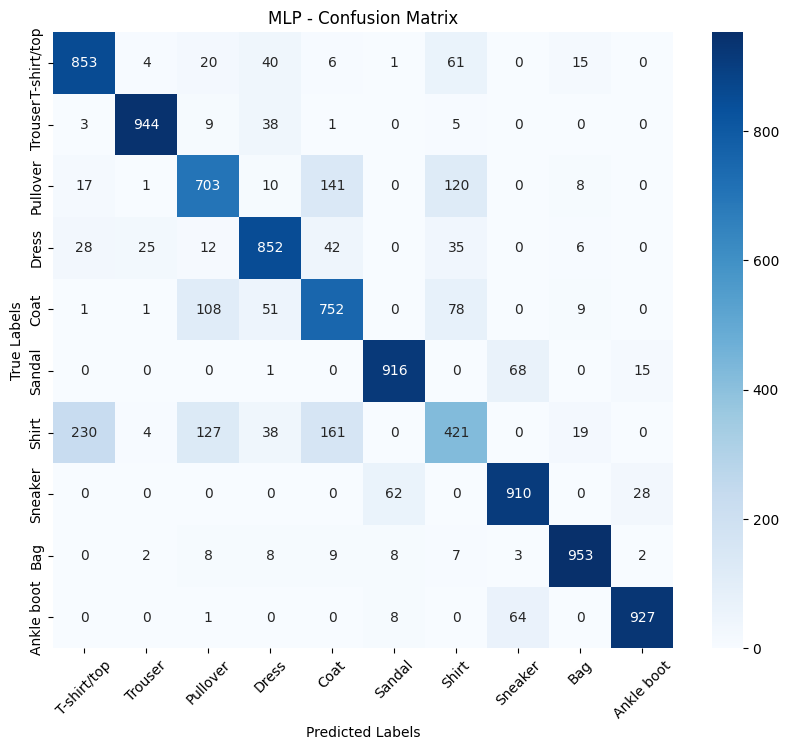

In [ ]:
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return np.array(all_preds), np.array(all_targets)

y_pred, y_true = get_predictions(mlp_fashion, test_loader, device)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("Classification Report (MLP):")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('MLP - Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

### Fruit

In [ ]:
# Define MLP for Fruits-360
class MLPFruits(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLPFruits, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Convert TensorFlow preprocessed data to PyTorch tensors
x_train_fruits_torch = torch.tensor(reduced_train_features_fruits, dtype=torch.float32)
x_test_fruits_torch = torch.tensor(reduced_test_features_fruits, dtype=torch.float32)
y_train_fruits_torch = torch.tensor(y_train_fruits, dtype=torch.long)
y_test_fruits_torch = torch.tensor(y_test_fruits, dtype=torch.long)

# Split training data into training and validation sets
train_size = int(0.8 * len(x_train_fruits_torch))
val_size = len(x_train_fruits_torch) - train_size
train_dataset_fruits = TensorDataset(x_train_fruits_torch, y_train_fruits_torch)
train_dataset_fruits, val_dataset_fruits = random_split(train_dataset_fruits, [train_size, val_size])

train_loader_fruits = DataLoader(train_dataset_fruits, batch_size=64, shuffle=True)
val_loader_fruits = DataLoader(val_dataset_fruits, batch_size=64, shuffle=False)
test_loader_fruits = DataLoader(TensorDataset(x_test_fruits_torch, y_test_fruits_torch), batch_size=64, shuffle=False)

Epoch [1/20] Train Loss: 2.7063, Train Acc: 0.3117, Val Loss: 0.8304, Val Acc: 0.8108
Epoch [2/20] Train Loss: 1.2575, Train Acc: 0.6182, Val Loss: 0.3990, Val Acc: 0.9101
Epoch [3/20] Train Loss: 0.9414, Train Acc: 0.7026, Val Loss: 0.2794, Val Acc: 0.9362
Epoch [4/20] Train Loss: 0.8012, Train Acc: 0.7432, Val Loss: 0.2142, Val Acc: 0.9459
Epoch [5/20] Train Loss: 0.7296, Train Acc: 0.7632, Val Loss: 0.1749, Val Acc: 0.9573
Epoch [6/20] Train Loss: 0.6612, Train Acc: 0.7841, Val Loss: 0.1405, Val Acc: 0.9703
Epoch [7/20] Train Loss: 0.6143, Train Acc: 0.7982, Val Loss: 0.1283, Val Acc: 0.9695
Epoch [8/20] Train Loss: 0.5749, Train Acc: 0.8088, Val Loss: 0.1146, Val Acc: 0.9738
Epoch [9/20] Train Loss: 0.5477, Train Acc: 0.8173, Val Loss: 0.1019, Val Acc: 0.9784
Epoch [10/20] Train Loss: 0.5279, Train Acc: 0.8237, Val Loss: 0.0919, Val Acc: 0.9774
Epoch [11/20] Train Loss: 0.5105, Train Acc: 0.8302, Val Loss: 0.0893, Val Acc: 0.9804
Epoch [12/20] Train Loss: 0.4910, Train Acc: 0.8344,

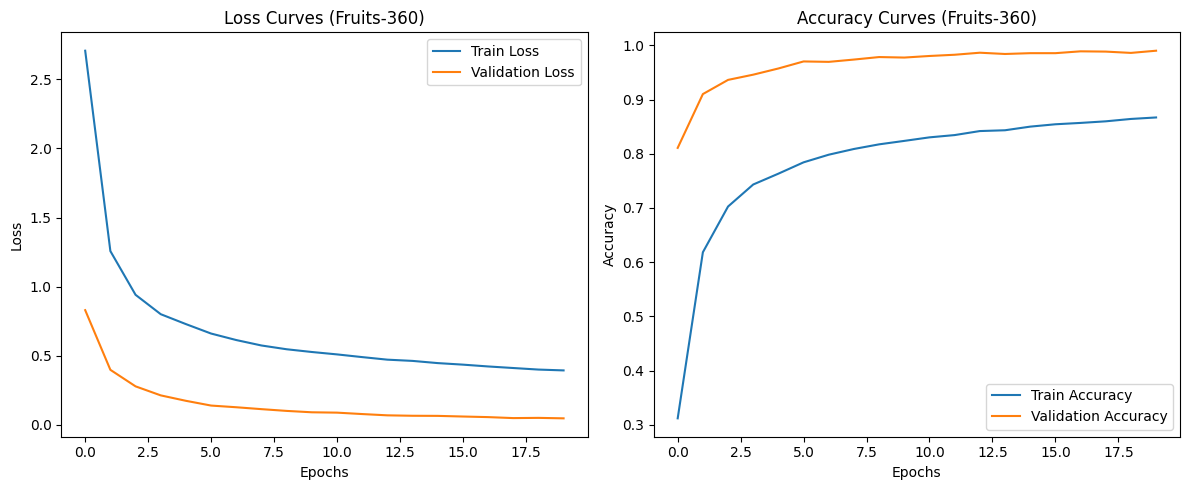

In [ ]:
# Instantiate the model
num_classes = len(torch.unique(y_train_fruits_torch))  # 141 classes
mlp_fruits = MLPFruits(x_train_fruits_torch.shape[1], num_classes).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_fruits.parameters(), lr=0.001)

# Training loop
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(loader)
    train_acc = correct / total
    return train_loss, train_acc

# Validation loop
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss = running_loss / len(loader)
    val_acc = correct / total
    return val_loss, val_acc

# Training the model
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_fruits.to(device)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(mlp_fruits, train_loader_fruits, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(mlp_fruits, val_loader_fruits, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Evaluate on test set
test_loss, test_acc = validate_epoch(mlp_fruits, test_loader_fruits, criterion, device)
print(f"Fruits-360 Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves (Fruits-360)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy Curves (Fruits-360)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Classification Report (MLP Fruits-360):
                       precision    recall  f1-score   support

      Eggplant long 1       1.00      1.00      1.00        80
             Quince 1       1.00      1.00      1.00       166
      Passion Fruit 1       0.99      1.00      0.99       166
             Cherry 2       0.86      1.00      0.92       246
         Peach Flat 1       0.92      0.75      0.83       164
          Blueberry 1       0.92      1.00      0.96       154
           Rambutan 1       0.90      0.99      0.94       164
           Mulberry 1       0.93      0.95      0.94       164
         Watermelon 1       0.83      0.95      0.89       157
          Apple hit 1       0.97      1.00      0.98       234
             Papaya 1       1.00      1.00      1.00       164
           Hazelnut 1       1.00      1.00      1.00       157
          Corn Husk 1       1.00      0.64      0.78       154
          Apple Red 3       0.76      0.69      0.72       144
          Mand

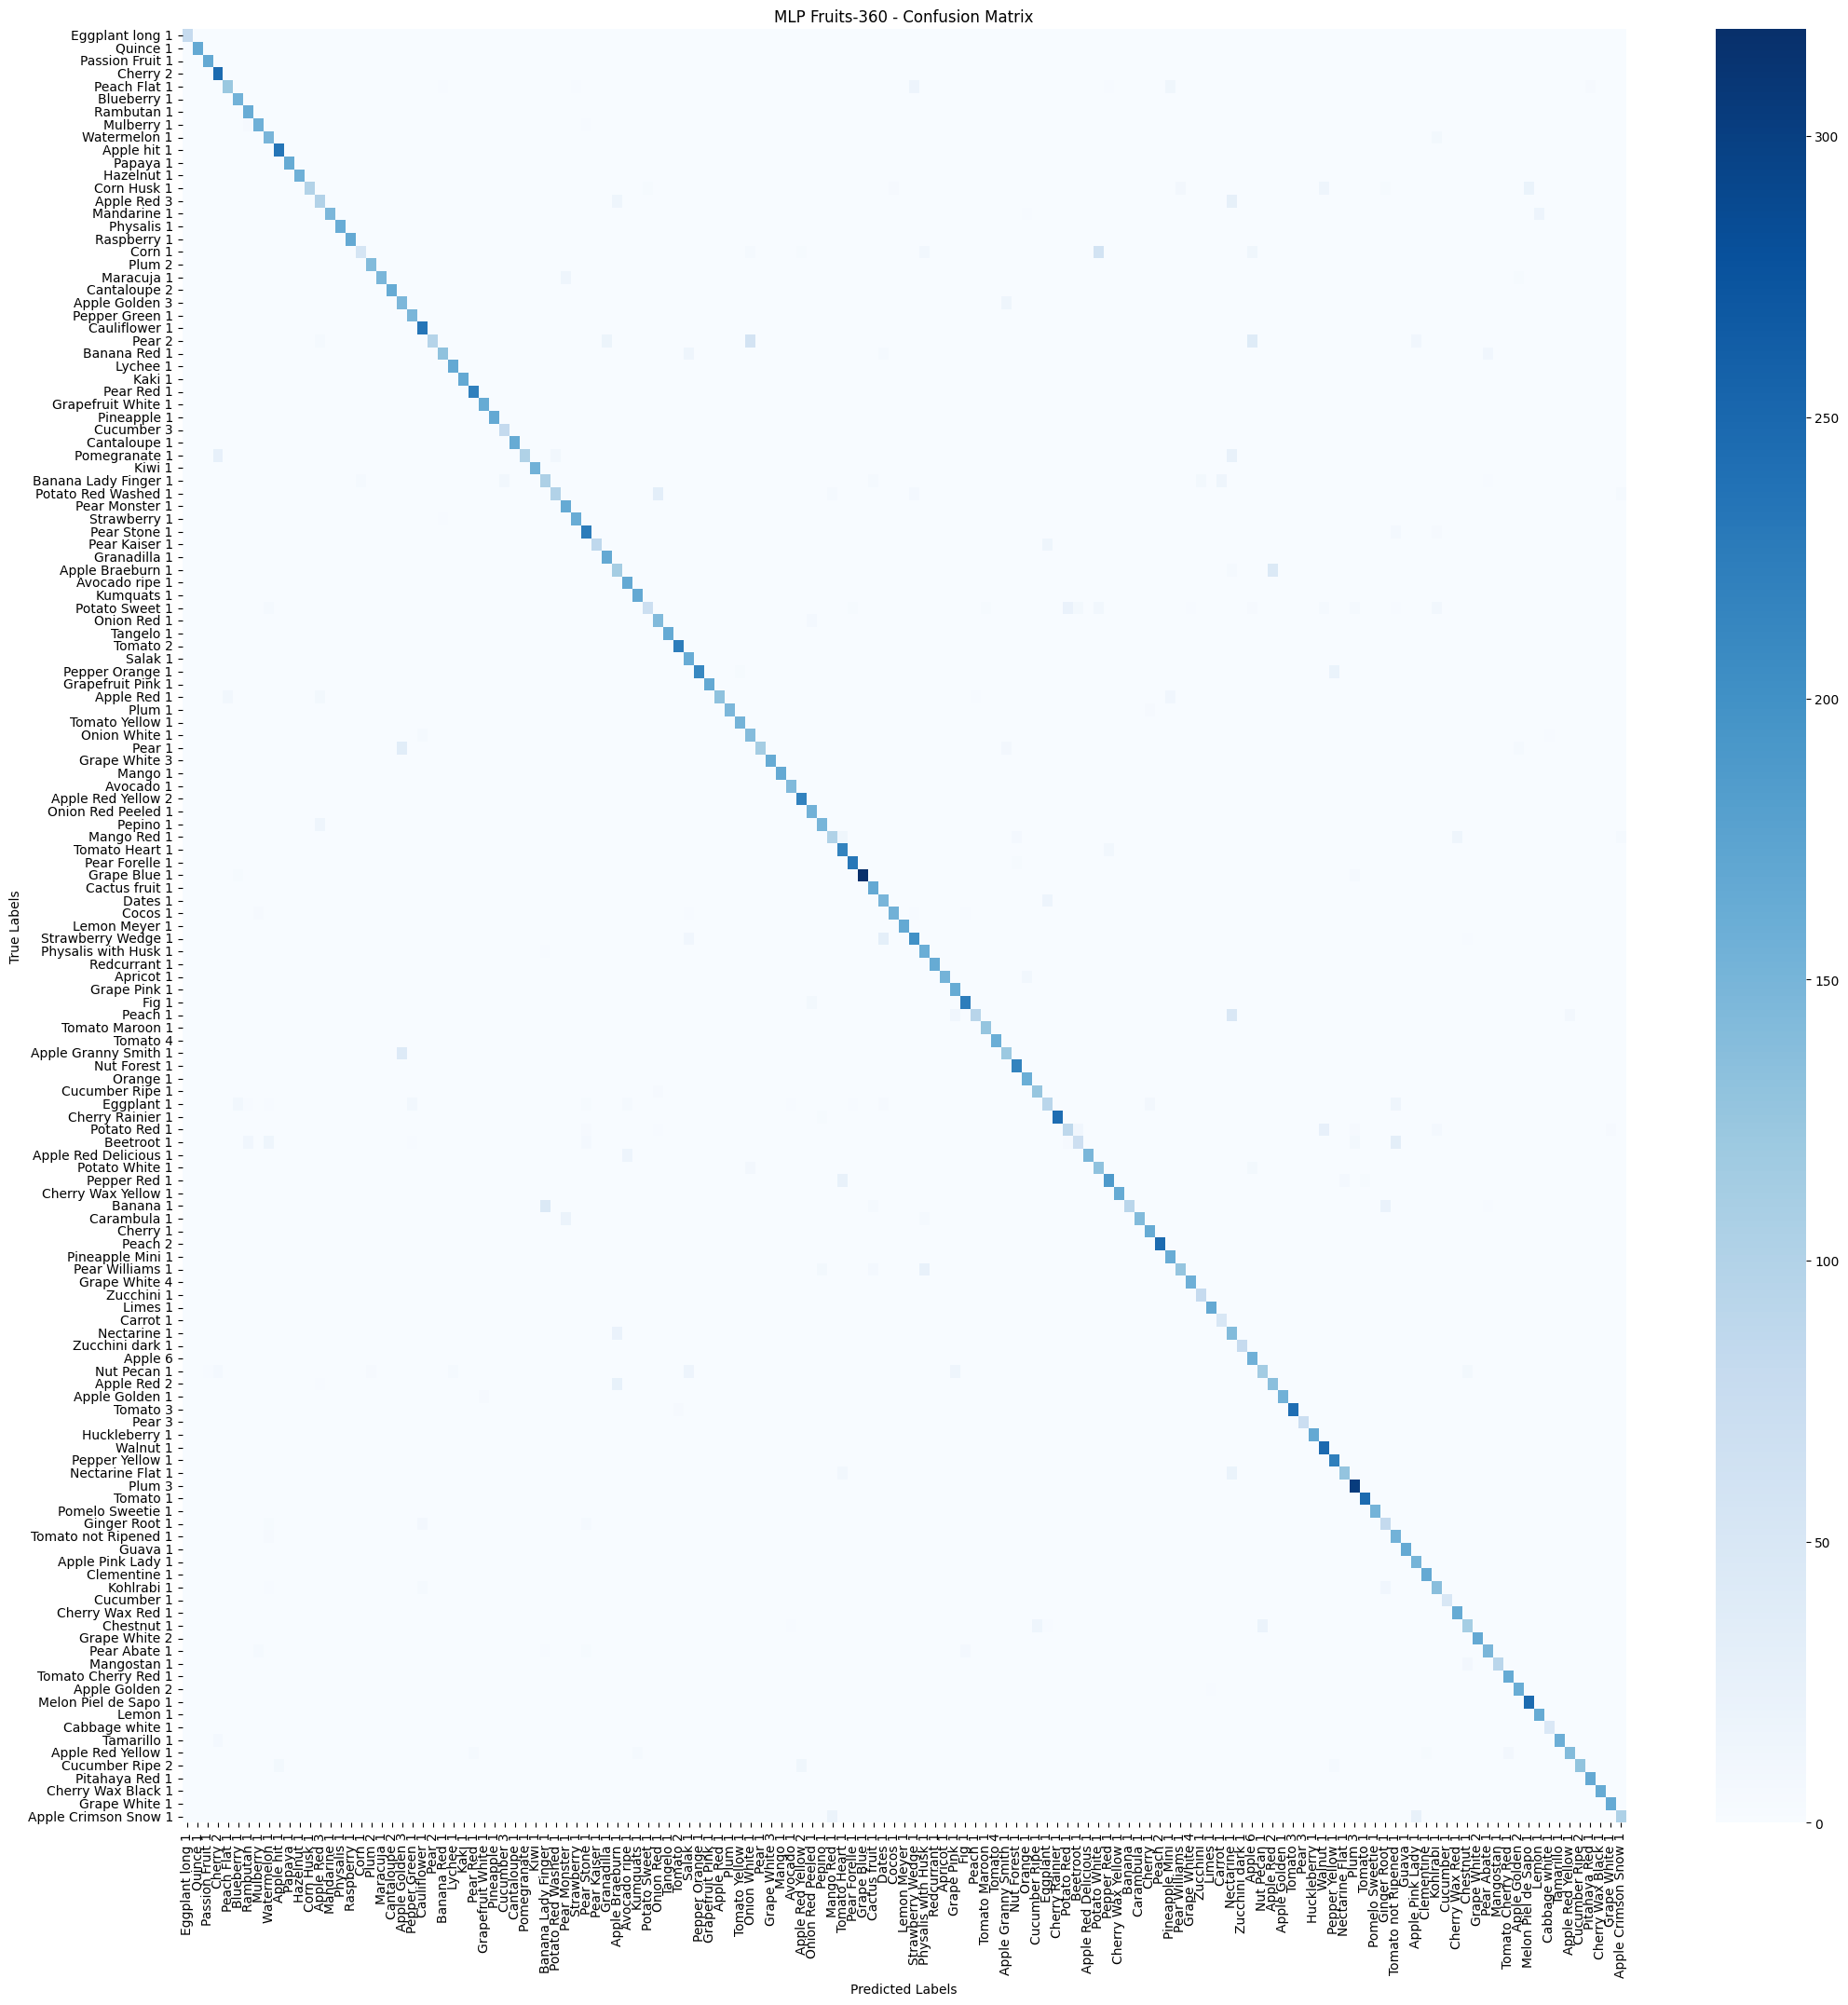

In [ ]:
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return np.array(all_preds), np.array(all_targets)

y_pred_fruits, y_true_fruits = get_predictions(mlp_fruits, test_loader_fruits, device)

print("Classification Report (MLP Fruits-360):")
print(classification_report(y_true_fruits, y_pred_fruits, target_names=list(label_map_train.values())))

cm = confusion_matrix(y_true_fruits, y_pred_fruits)

plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=False, cmap='Blues', cbar=True,
            xticklabels=list(label_map_train.values()),
            yticklabels=list(label_map_train.values()))
plt.xticks(rotation=90)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('MLP Fruits-360 - Confusion Matrix')
plt.show()

## MLP for images

### Fashion

In [ ]:
# Define MLP model
class MLPFashionMNIST(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLPFashionMNIST, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Flatten the images
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Convert data to PyTorch tensors
x_train_flat_torch = torch.tensor(x_train_flat, dtype=torch.float32)
x_test_flat_torch = torch.tensor(x_test_flat, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

# Split training data for validation
train_dataset = TensorDataset(x_train_flat_torch, y_train_torch)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

test_dataset = TensorDataset(x_test_flat_torch, y_test_torch)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Epoch 1/20, Train Loss: 0.6231, Val Loss: 0.4341, Train Acc: 0.7759, Val Acc: 0.8419
Epoch 2/20, Train Loss: 0.4343, Val Loss: 0.3690, Train Acc: 0.8438, Val Acc: 0.8634
Epoch 3/20, Train Loss: 0.3985, Val Loss: 0.3650, Train Acc: 0.8551, Val Acc: 0.8682
Epoch 4/20, Train Loss: 0.3754, Val Loss: 0.3434, Train Acc: 0.8634, Val Acc: 0.8732
Epoch 5/20, Train Loss: 0.3589, Val Loss: 0.3265, Train Acc: 0.8696, Val Acc: 0.8809
Epoch 6/20, Train Loss: 0.3474, Val Loss: 0.3229, Train Acc: 0.8721, Val Acc: 0.8824
Epoch 7/20, Train Loss: 0.3325, Val Loss: 0.3227, Train Acc: 0.8765, Val Acc: 0.8812
Epoch 8/20, Train Loss: 0.3265, Val Loss: 0.3192, Train Acc: 0.8801, Val Acc: 0.8819
Epoch 9/20, Train Loss: 0.3174, Val Loss: 0.3287, Train Acc: 0.8819, Val Acc: 0.8814
Epoch 10/20, Train Loss: 0.3116, Val Loss: 0.3044, Train Acc: 0.8858, Val Acc: 0.8883
Epoch 11/20, Train Loss: 0.3026, Val Loss: 0.3124, Train Acc: 0.8884, Val Acc: 0.8879
Epoch 12/20, Train Loss: 0.2997, Val Loss: 0.3035, Train Acc: 0

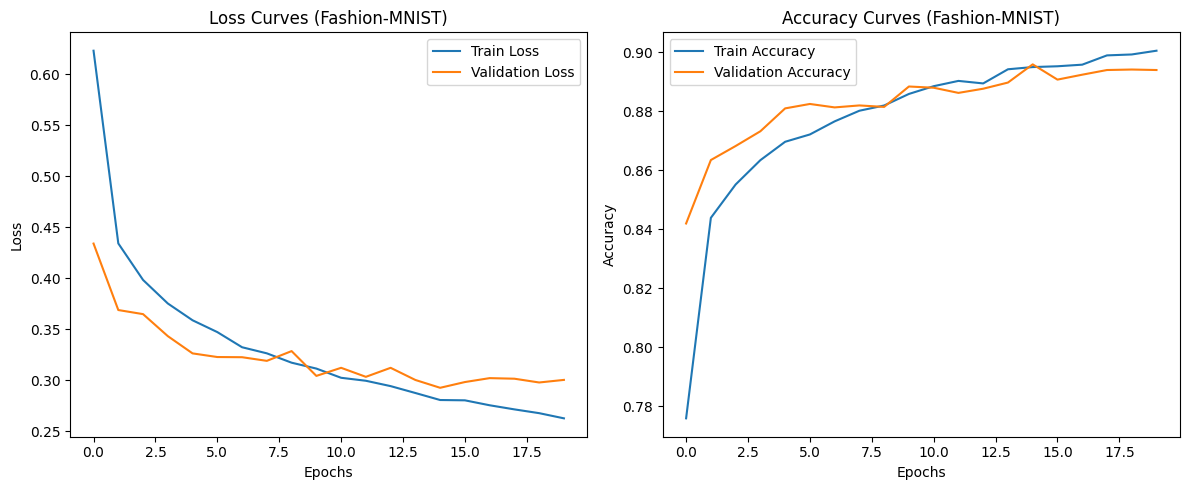

In [ ]:
# Instantiate model, define loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_fashion = MLPFashionMNIST(x_train_flat_torch.shape[1], 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_fashion.parameters(), lr=0.001)

# Training and validation loops
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return running_loss / len(loader), correct / total

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return running_loss / len(loader), correct / total

# Training loop
num_epochs = 20
train_losses, val_losses, train_accs, val_accs = [], [], [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(mlp_fashion, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(mlp_fashion, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Evaluate on test set
test_loss, test_acc = validate_epoch(mlp_fashion, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves (Fashion-MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy Curves (Fashion-MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Classification Report (Fashion-MNIST):
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.81      0.83      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.80      0.78      0.79      1000
       Dress       0.86      0.92      0.89      1000
        Coat       0.79      0.81      0.80      1000
      Sandal       0.96      0.98      0.97      1000
       Shirt       0.71      0.69      0.70      1000
     Sneaker       0.95      0.96      0.95      1000
         Bag       0.97      0.98      0.97      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



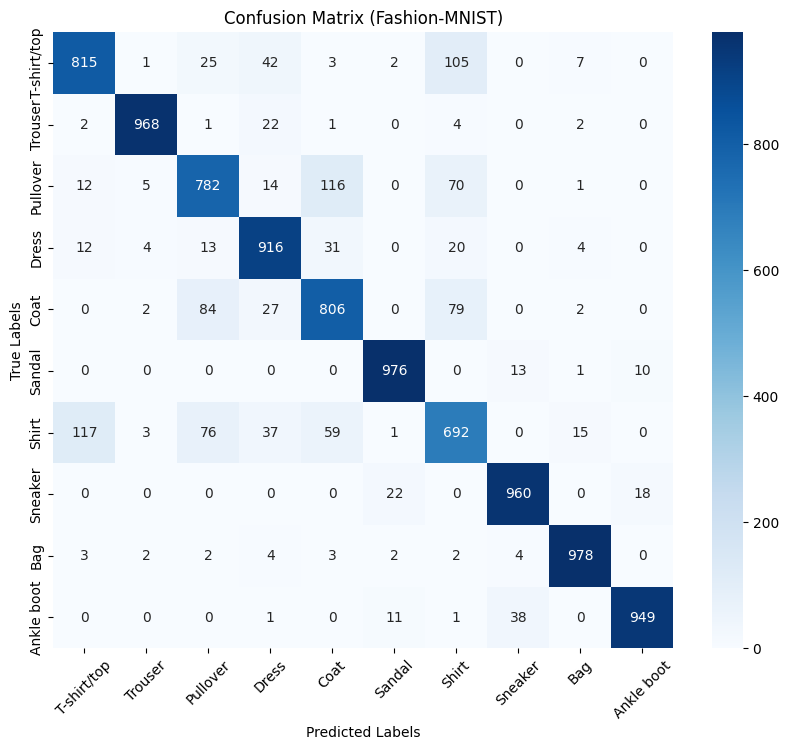

In [ ]:
# Classification report and confusion matrix
def get_predictions(model, loader, device):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    return np.array(all_preds), np.array(all_targets)

y_pred, y_true = get_predictions(mlp_fashion, test_loader, device)

print("Classification Report (Fashion-MNIST):")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=45)
plt.title('Confusion Matrix (Fashion-MNIST)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Fruit

In [ ]:
def load_fruits_from_directory(directory, image_size=(28, 28)):
    images = []
    labels = []
    label_map = {}
    label = 0

    for fruit in sorted(os.listdir(directory)):
        fruit_path = os.path.join(directory, fruit)
        if os.path.isdir(fruit_path):
            label_map[label] = fruit
            for image_file in os.listdir(fruit_path):
                image_path = os.path.join(fruit_path, image_file)
                image = Image.open(image_path).resize(image_size)
                images.append(np.array(image))
                labels.append(label)
            label += 1

    images = np.array(images)
    labels = np.array(labels)
    return images, labels, label_map

# Load training and testing data
x_train_fruits, y_train_fruits, label_map_train = load_fruits_from_directory(train_dir)
x_test_fruits, y_test_fruits, label_map_test = load_fruits_from_directory(test_dir)

# Normalize the images
x_train_fruits = x_train_fruits / 255.0
x_test_fruits = x_test_fruits / 255.0

# Flatten the images
x_train_flat_fruits = x_train_fruits.reshape(x_train_fruits.shape[0], -1)
x_test_flat_fruits = x_test_fruits.reshape(x_test_fruits.shape[0], -1)

# Convert data to PyTorch tensors
x_train_flat_fruits_torch = torch.tensor(x_train_flat_fruits, dtype=torch.float32)
x_test_flat_fruits_torch = torch.tensor(x_test_flat_fruits, dtype=torch.float32)
y_train_fruits_torch = torch.tensor(y_train_fruits, dtype=torch.long)
y_test_fruits_torch = torch.tensor(y_test_fruits, dtype=torch.long)

# Split training data for validation
train_dataset_fruits = TensorDataset(x_train_flat_fruits_torch, y_train_fruits_torch)
train_size = int(0.8 * len(train_dataset_fruits))
val_size = len(train_dataset_fruits) - train_size
train_dataset_fruits, val_dataset_fruits = random_split(train_dataset_fruits, [train_size, val_size])

# Create DataLoaders
train_loader_fruits = DataLoader(train_dataset_fruits, batch_size=64, shuffle=True)
val_loader_fruits = DataLoader(val_dataset_fruits, batch_size=64, shuffle=False)
test_loader_fruits = DataLoader(TensorDataset(x_test_flat_fruits_torch, y_test_fruits_torch), batch_size=64, shuffle=False)

In [ ]:
# Define MLP model for Fruits-360
class MLPFruits360(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLPFruits360, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)

Epoch 1/20: Train Loss=2.5720, Train Acc=0.3051, Val Loss=0.9031, Val Acc=0.7671
Epoch 2/20: Train Loss=1.3399, Train Acc=0.5730, Val Loss=0.5065, Val Acc=0.8762
Epoch 3/20: Train Loss=1.0961, Train Acc=0.6481, Val Loss=0.3996, Val Acc=0.8904
Epoch 4/20: Train Loss=0.9590, Train Acc=0.6893, Val Loss=0.3090, Val Acc=0.9262
Epoch 5/20: Train Loss=0.8698, Train Acc=0.7169, Val Loss=0.2691, Val Acc=0.9276
Epoch 6/20: Train Loss=0.8095, Train Acc=0.7352, Val Loss=0.2149, Val Acc=0.9469
Epoch 7/20: Train Loss=0.7709, Train Acc=0.7504, Val Loss=0.2109, Val Acc=0.9489
Epoch 8/20: Train Loss=0.7353, Train Acc=0.7630, Val Loss=0.2085, Val Acc=0.9504
Epoch 9/20: Train Loss=0.7027, Train Acc=0.7749, Val Loss=0.1799, Val Acc=0.9580
Epoch 10/20: Train Loss=0.6743, Train Acc=0.7836, Val Loss=0.1632, Val Acc=0.9563
Epoch 11/20: Train Loss=0.6632, Train Acc=0.7826, Val Loss=0.1486, Val Acc=0.9660
Epoch 12/20: Train Loss=0.6387, Train Acc=0.7946, Val Loss=0.1304, Val Acc=0.9674
Epoch 13/20: Train Loss=0

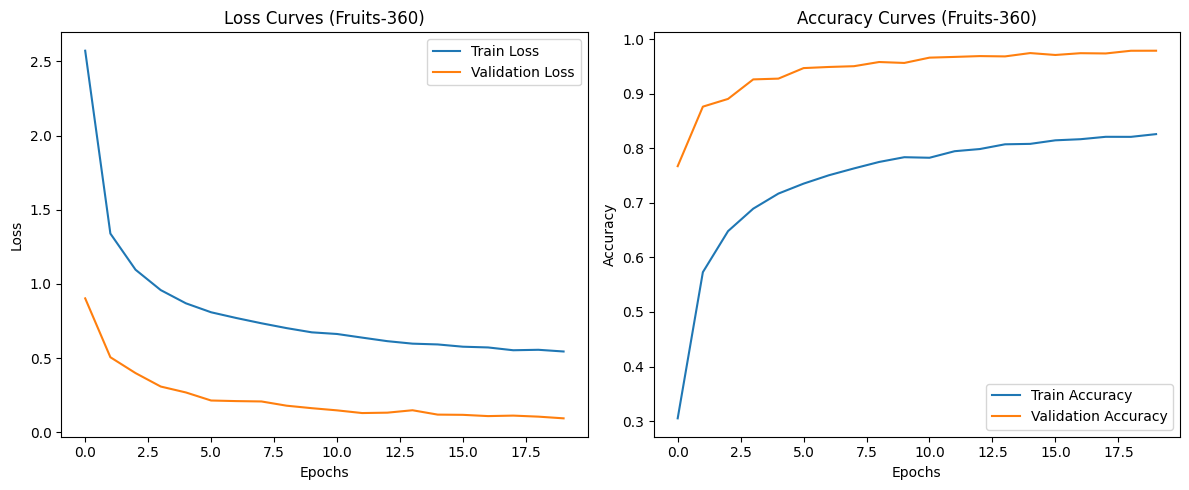

In [ ]:
# Instantiate model, define loss and optimizer
num_classes = len(label_map_train)
mlp_fruits = MLPFruits360(x_train_flat_fruits_torch.shape[1], num_classes).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_fruits.parameters(), lr=0.001)

# Training and validation loops
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return running_loss / len(loader), correct / total

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return running_loss / len(loader), correct / total

# Training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(mlp_fruits, train_loader_fruits, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(mlp_fruits, val_loader_fruits, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

# Evaluate on test set
test_loss, test_acc = validate_epoch(mlp_fruits, test_loader_fruits, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves (Fruits-360)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy Curves (Fruits-360)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Classification Report (Fruits-360):
                       precision    recall  f1-score   support

              Apple 6       0.72      1.00      0.84       157
     Apple Braeburn 1       1.00      0.55      0.71       164
 Apple Crimson Snow 1       0.99      1.00      1.00       148
       Apple Golden 1       1.00      1.00      1.00       160
       Apple Golden 2       0.97      1.00      0.98       164
       Apple Golden 3       0.67      1.00      0.80       161
 Apple Granny Smith 1       1.00      0.81      0.90       164
    Apple Pink Lady 1       0.76      0.40      0.53       152
          Apple Red 1       0.84      0.87      0.86       164
          Apple Red 2       0.64      1.00      0.78       164
          Apple Red 3       0.92      1.00      0.96       144
Apple Red Delicious 1       0.92      1.00      0.96       166
   Apple Red Yellow 1       0.86      0.83      0.84       164
   Apple Red Yellow 2       1.00      0.99      1.00       219
          Apple hi

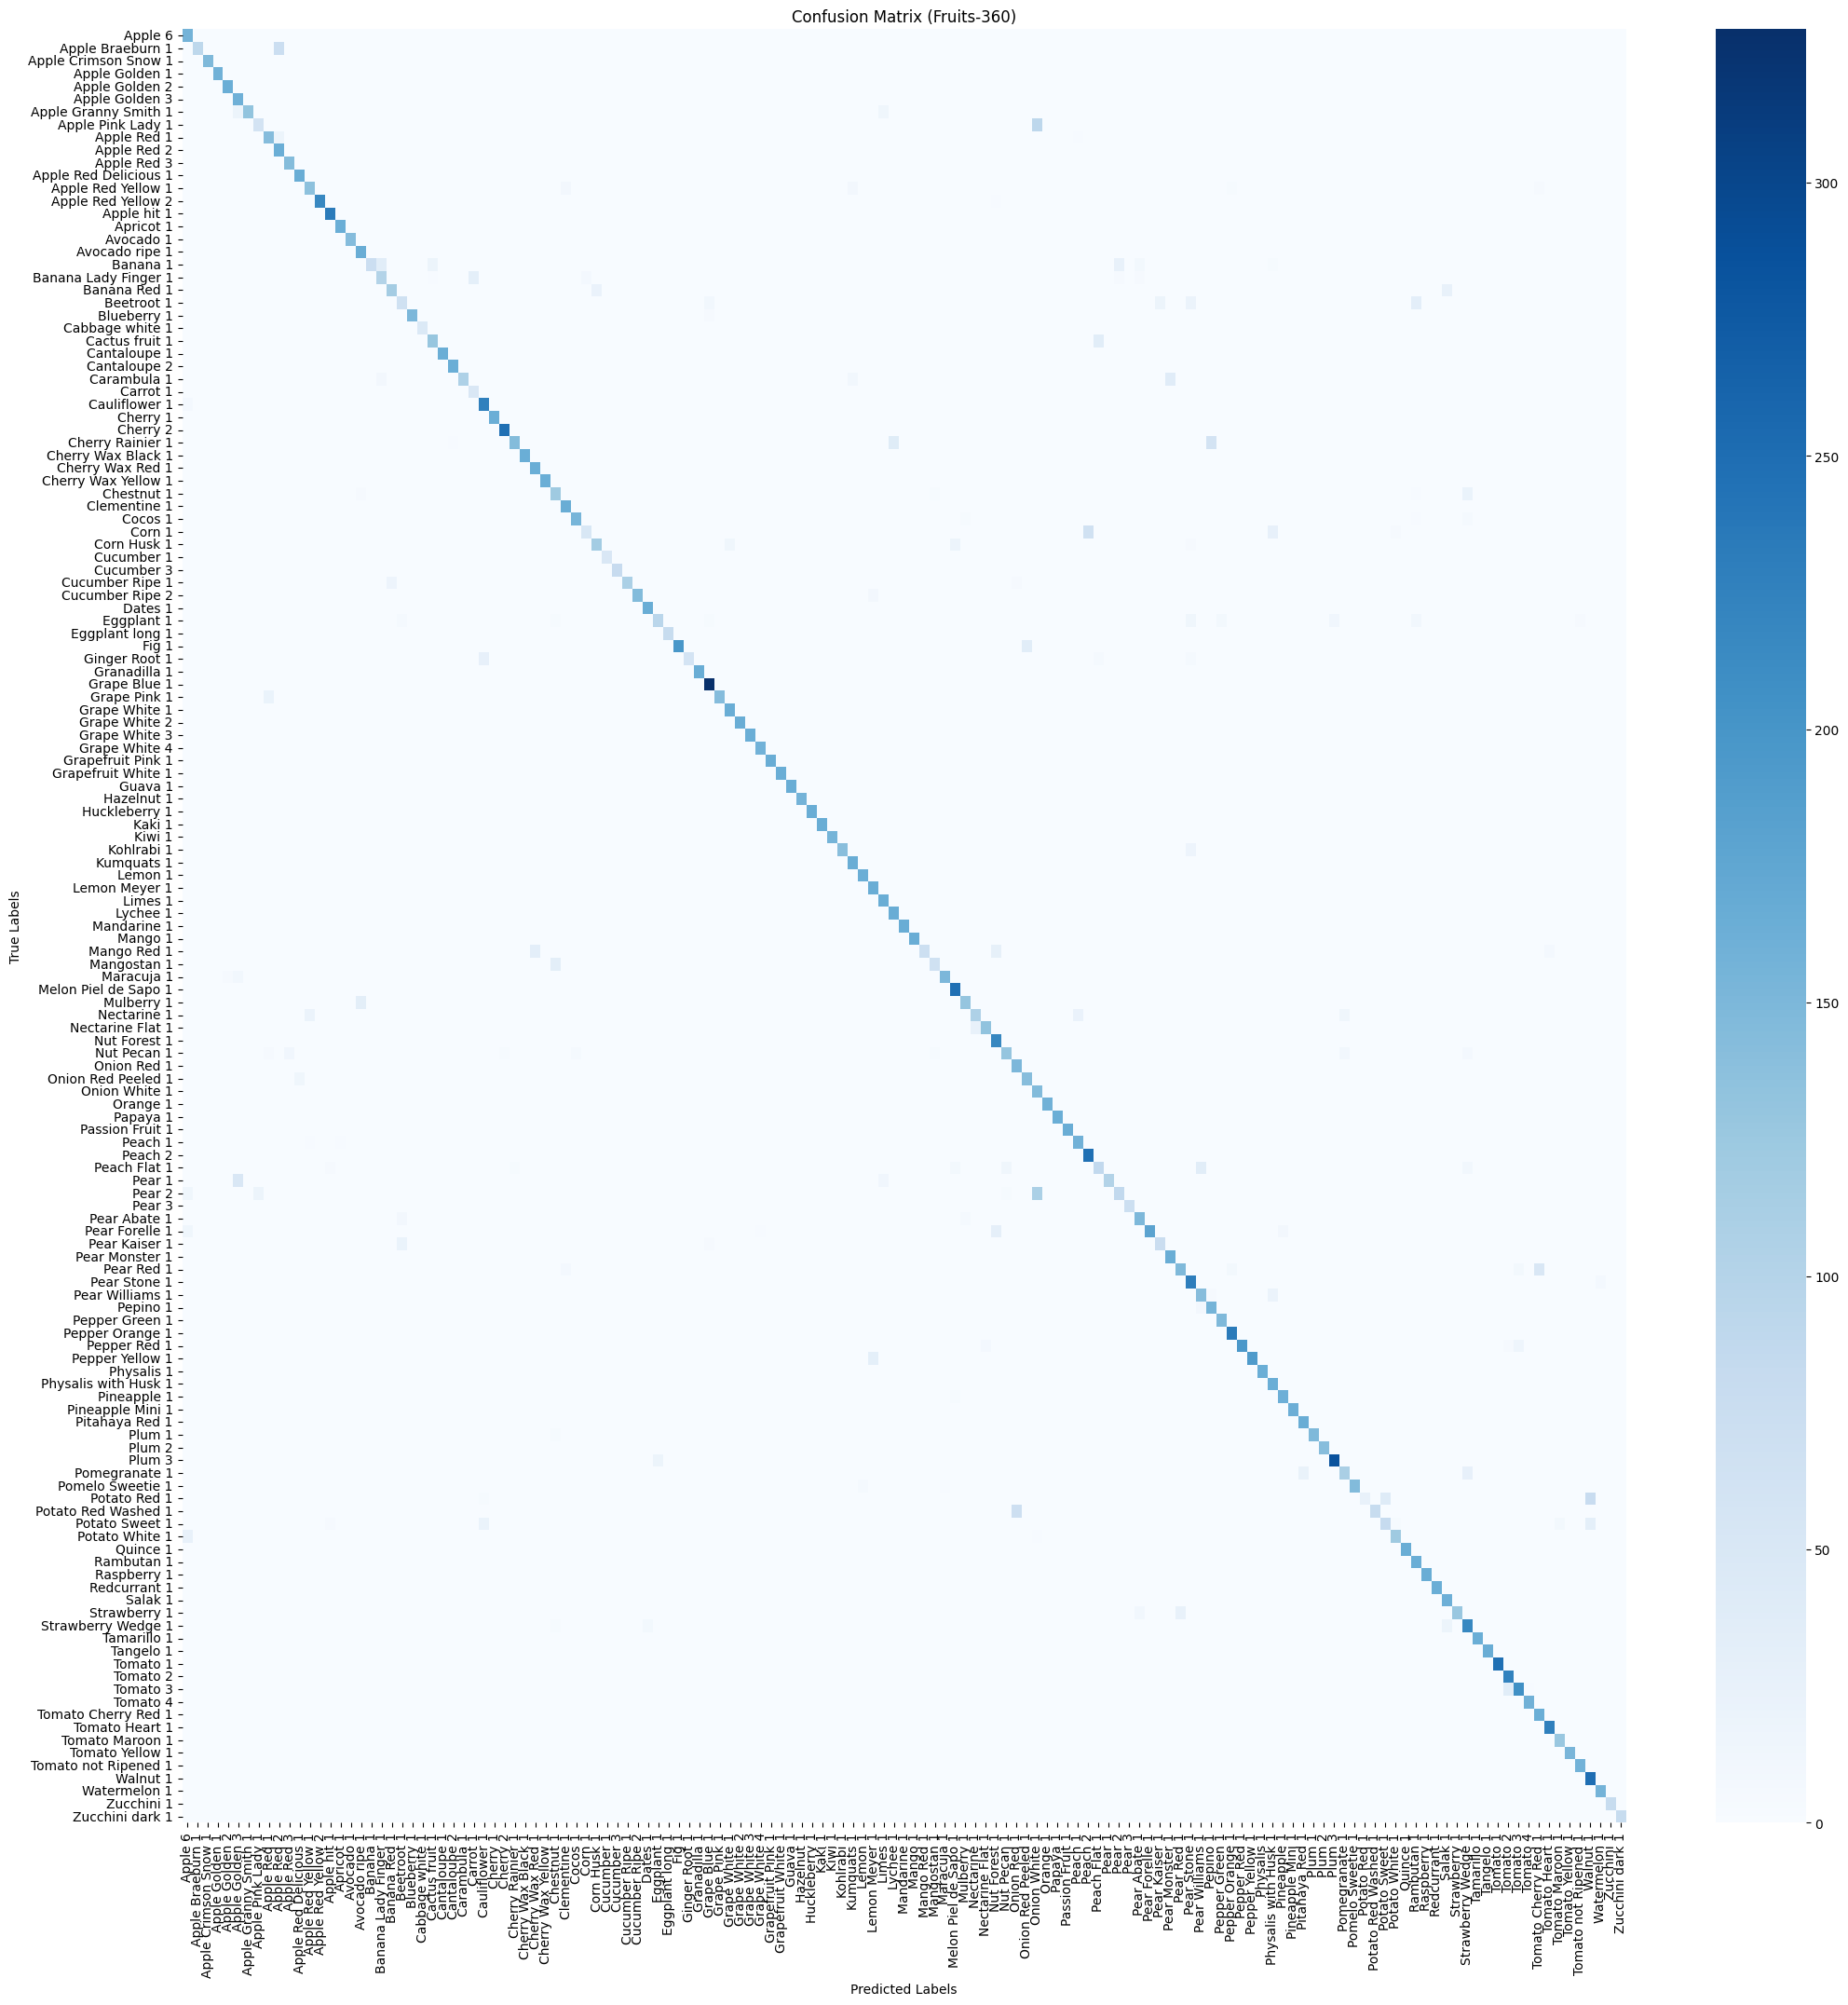

In [ ]:
# Classification report and confusion matrix
def get_predictions(model, loader, device):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    return np.array(all_preds), np.array(all_targets)

y_pred_fruits, y_true_fruits = get_predictions(mlp_fruits, test_loader_fruits, device)

print("Classification Report (Fruits-360):")
print(classification_report(y_true_fruits, y_pred_fruits, target_names=list(label_map_train.values())))

# Confusion matrix
cm_fruits = confusion_matrix(y_true_fruits, y_pred_fruits)
plt.figure(figsize=(25, 25))
sns.heatmap(cm_fruits, annot=False, cmap='Blues', xticklabels=list(label_map_train.values()), yticklabels=list(label_map_train.values()))
plt.xticks(rotation=90)
plt.title('Confusion Matrix (Fruits-360)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## CNN

### Fashion

In [ ]:
def load_fashion_mnist():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train / 255.0
    x_test = x_test / 255.0
    x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension for grayscale
    x_test = np.expand_dims(x_test, axis=-1)
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_fashion_mnist()

In [ ]:
# Convert to PyTorch tensors
x_train_torch = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, C, H, W)
x_test_torch = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

# Split training data into training and validation sets
dataset = TensorDataset(x_train_torch, y_train_torch)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader_no_aug = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(x_test_torch, y_test_torch), batch_size=64, shuffle=False)

In [ ]:
class CNNFashion(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNNFashion, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),

            nn.AdaptiveAvgPool2d((1, 1)),

            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
model_no_aug = CNNFashion(1, 10).to(device)
optimizer = optim.Adam(model_no_aug.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return running_loss / len(loader), correct / total

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return running_loss / len(loader), correct / total

train_losses_no_aug, val_losses_no_aug = [], []
train_accs_no_aug, val_accs_no_aug = [], []

for epoch in range(20):
    train_loss, train_acc = train_epoch(model_no_aug, train_loader_no_aug, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model_no_aug, val_loader, criterion, device)
    train_losses_no_aug.append(train_loss)
    val_losses_no_aug.append(val_loss)
    train_accs_no_aug.append(train_acc)
    val_accs_no_aug.append(val_acc)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

test_loss, test_acc = validate_epoch(model_no_aug, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Epoch 1: Train Loss=0.7479, Train Acc=0.7377, Val Loss=0.4082, Val Acc=0.8545
Epoch 2: Train Loss=0.4285, Train Acc=0.8503, Val Loss=0.3599, Val Acc=0.8704
Epoch 3: Train Loss=0.3682, Train Acc=0.8703, Val Loss=0.3274, Val Acc=0.8844
Epoch 4: Train Loss=0.3378, Train Acc=0.8824, Val Loss=0.3319, Val Acc=0.8799
Epoch 5: Train Loss=0.3161, Train Acc=0.8883, Val Loss=0.3220, Val Acc=0.8861
Epoch 6: Train Loss=0.3010, Train Acc=0.8917, Val Loss=0.2912, Val Acc=0.8950
Epoch 7: Train Loss=0.2872, Train Acc=0.8979, Val Loss=0.4392, Val Acc=0.8575
Epoch 8: Train Loss=0.2772, Train Acc=0.9009, Val Loss=0.3426, Val Acc=0.8800
Epoch 9: Train Loss=0.2674, Train Acc=0.9053, Val Loss=0.2759, Val Acc=0.9040
Epoch 10: Train Loss=0.2590, Train Acc=0.9062, Val Loss=0.3024, Val Acc=0.8935
Epoch 11: Train Loss=0.2546, Train Acc=0.9087, Val Loss=0.2771, Val Acc=0.9022
Epoch 12: Train Loss=0.2441, Train Acc=0.9127, Val Loss=0.2701, Val Acc=0.9072
Epoch 13: Train Loss=0.2408, Train Acc=0.9135, Val Loss=0.256

In [ ]:
# Data augmentation for Fashion-MNIST
fashion_transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor()
])

# Apply augmentation
augmented_dataset = datasets.FashionMNIST(root='./data', train=True, transform=fashion_transform_aug, download=True)
augmented_train_loader = DataLoader(augmented_dataset, batch_size=64, shuffle=True)

# Train with augmentation
model_aug = CNNFashion(1, 10).to(device)
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001)

train_losses_aug, val_losses_aug = [], []
train_accs_aug, val_accs_aug = [], []

for epoch in range(20):
    train_loss, train_acc = train_epoch(model_aug, augmented_train_loader, criterion, optimizer_aug, device)
    val_loss, val_acc = validate_epoch(model_aug, val_loader, criterion, device)
    train_losses_aug.append(train_loss)
    val_losses_aug.append(val_loss)
    train_accs_aug.append(train_acc)
    val_accs_aug.append(val_acc)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

test_loss_aug, test_acc_aug = validate_epoch(model_aug, test_loader, criterion, device)
print(f"Test Loss (With Aug): {test_loss_aug:.4f}, Test Acc: {test_acc_aug:.4f}")

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.67MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 142kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 2.71MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.86MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch 1: Train Loss=0.8971, Train Acc=0.6777, Val Loss=0.5364, Val Acc=0.8065
Epoch 2: Train Loss=0.6060, Train Acc=0.7845, Val Loss=0.5661, Val Acc=0.7989
Epoch 3: Train Loss=0.5522, Train Acc=0.8050, Val Loss=0.4406, Val Acc=0.8417
Epoch 4: Train Loss=0.5192, Train Acc=0.8157, Val Loss=0.4386, Val Acc=0.8384
Epoch 5: Train Loss=0.5008, Train Acc=0.8229, Val Loss=0.4519, Val Acc=0.8333
Epoch 6: Train Loss=0.4813, Train Acc=0.8293, Val Loss=0.3962, Val Acc=0.8556
Epoch 7: Train Loss=0.4706, Train Acc=0.8331, Val Loss=0.3541, Val Acc=0.8676
Epoch 8: Train Loss=0.4616, Train Acc=0.8382, Val Loss=0.3340, Val Acc=0.8810
Epoch 9: Train Loss=0.4497, Train Acc=0.8412, Val Loss=0.3439, Val Acc=0.8758
Epoch 10: Train Loss=0.4459, Train Acc=0.8407, Val Loss=0.3505, Val Acc=0.8750
Epoch 11: Train Loss=0.4360, Train Acc=0.8465, Val Loss=0.3515, Val Acc=0.8738
Epoch 12: Train Loss=0.4275, Train Acc=0.8467, Val 

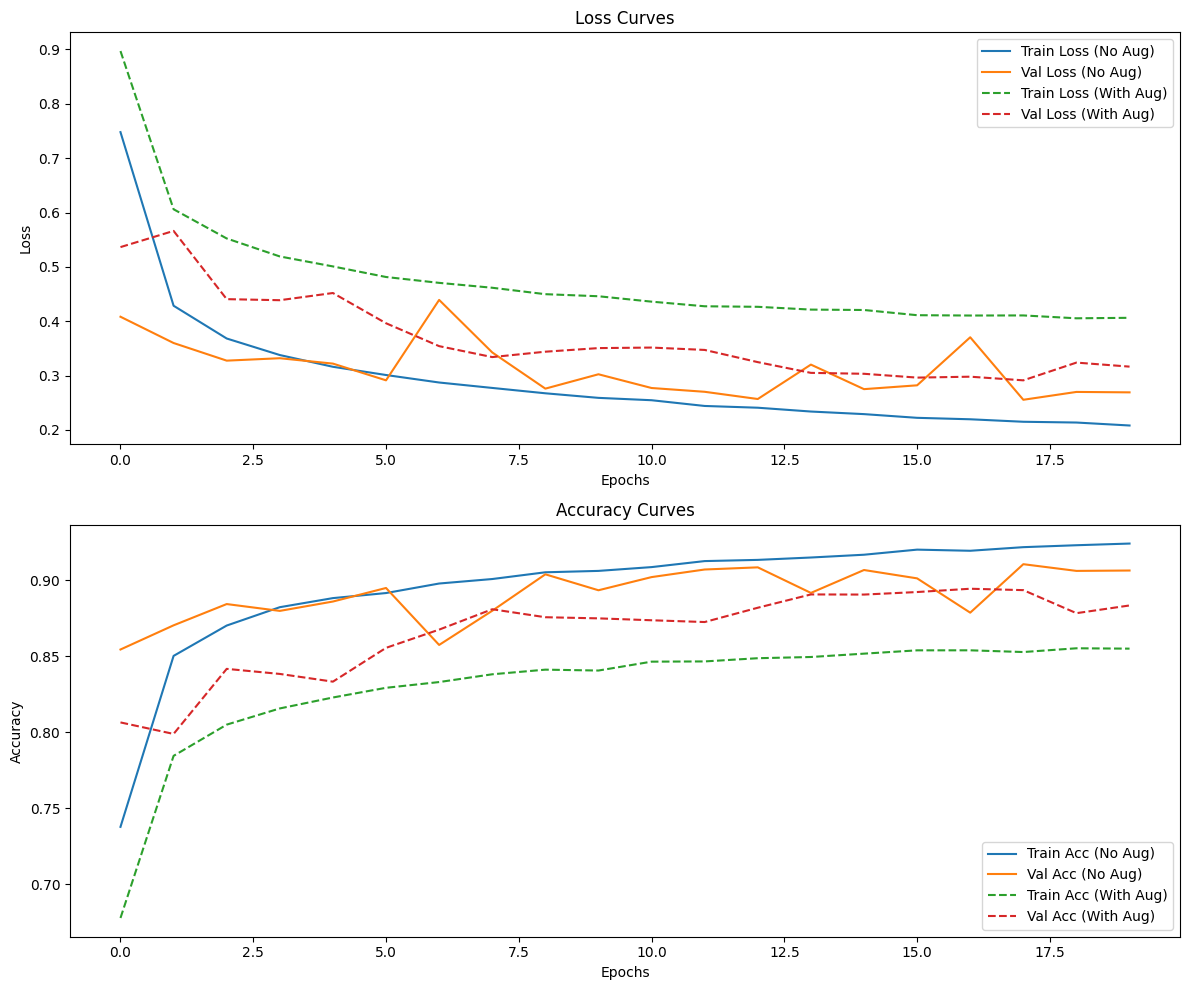

In [ ]:
plt.figure(figsize=(12, 10))

# Loss comparison
plt.subplot(2, 1, 1)
plt.plot(train_losses_no_aug, label='Train Loss (No Aug)')
plt.plot(val_losses_no_aug, label='Val Loss (No Aug)')
plt.plot(train_losses_aug, label='Train Loss (With Aug)', linestyle='dashed')
plt.plot(val_losses_aug, label='Val Loss (With Aug)', linestyle='dashed')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy comparison
plt.subplot(2, 1, 2)
plt.plot(train_accs_no_aug, label='Train Acc (No Aug)')
plt.plot(val_accs_no_aug, label='Val Acc (No Aug)')
plt.plot(train_accs_aug, label='Train Acc (With Aug)', linestyle='dashed')
plt.plot(val_accs_aug, label='Val Acc (With Aug)', linestyle='dashed')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Classification Report (No Aug):
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.89      0.85      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.88      0.84      0.86      1000
       Dress       0.90      0.87      0.88      1000
        Coat       0.76      0.92      0.83      1000
      Sandal       0.98      0.97      0.97      1000
       Shirt       0.80      0.61      0.69      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.97      0.98      0.98      1000
  Ankle boot       0.98      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Classification Report (With Aug):
              precision    recall  f1-score   support

 T-shirt/top       0.73      0.92      0.81      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover

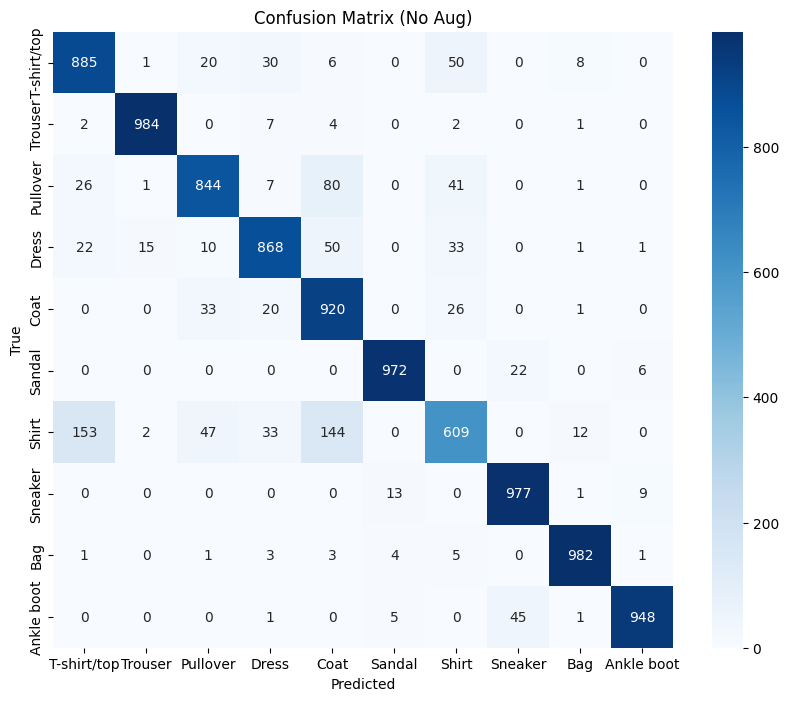

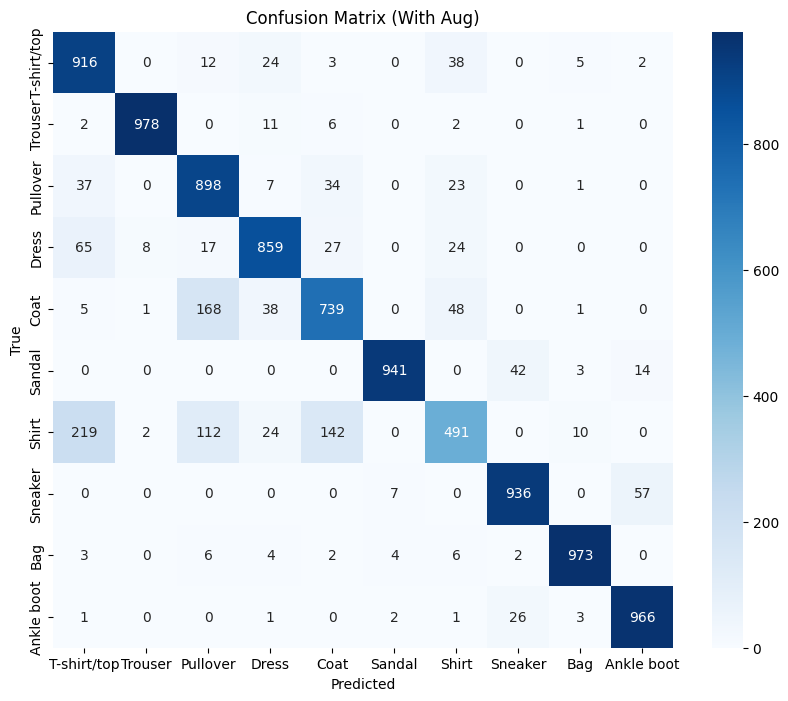

In [ ]:
def evaluate_model(model, loader, device):
	model.eval()
	all_preds, all_targets = [], []
	with torch.no_grad():
		for inputs, targets in loader:
			inputs, targets = inputs.to(device), targets.to(device)
			outputs = model(inputs)
			_, predicted = outputs.max(1)
			all_preds.extend(predicted.cpu().numpy())
			all_targets.extend(targets.cpu().numpy())
	return np.array(all_preds), np.array(all_targets)

# Evaluate both models
y_pred_no_aug, y_true = evaluate_model(model_no_aug, test_loader, device)
y_pred_aug, _ = evaluate_model(model_aug, test_loader, device)

# Classification reports
print("Classification Report (No Aug):")
print(classification_report(y_true, y_pred_no_aug, target_names=class_names))

print("Classification Report (With Aug):")
print(classification_report(y_true, y_pred_aug, target_names=class_names))

# Confusion matrix for No Aug
cm_no_aug = confusion_matrix(y_true, y_pred_no_aug)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_aug, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (No Aug)')
plt.show()

# Confusion matrix for With Aug
cm_aug = confusion_matrix(y_true, y_pred_aug)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (With Aug)')
plt.show()

### Fruit

In [ ]:
# Load data
x_train_fruits, y_train_fruits, label_map_train = load_fruits_from_directory(train_dir)
x_test_fruits, y_test_fruits, label_map_test = load_fruits_from_directory(test_dir)

# Convert to PyTorch tensors
x_train_fruits_torch = torch.tensor(x_train_fruits, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
x_test_fruits_torch = torch.tensor(x_test_fruits, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
y_train_fruits_torch = torch.tensor(y_train_fruits, dtype=torch.long)
y_test_fruits_torch = torch.tensor(y_test_fruits, dtype=torch.long)

# Split training data into training and validation sets
dataset_fruits = TensorDataset(x_train_fruits_torch, y_train_fruits_torch)
train_size = int(0.8 * len(dataset_fruits))
val_size = len(dataset_fruits) - train_size
fruits_train_dataset, fruits_val_dataset = random_split(dataset_fruits, [train_size, val_size])

fruits_train_loader_no_aug = DataLoader(fruits_train_dataset, batch_size=64, shuffle=True)
fruits_val_loader = DataLoader(fruits_val_dataset, batch_size=64, shuffle=False)
fruits_test_loader = DataLoader(TensorDataset(x_test_fruits_torch, y_test_fruits_torch), batch_size=64, shuffle=False)

In [ ]:
class CNNFruits(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNNFruits, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),

            nn.AdaptiveAvgPool2d((1, 1)),

            nn.Flatten(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Train without augmentation
model_no_aug_fruits = CNNFruits(3, 141).to(device)
optimizer_no_aug_fruits = optim.Adam(model_no_aug_fruits.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses_no_aug_fruits, val_losses_no_aug_fruits = [], []
train_accs_no_aug_fruits, val_accs_no_aug_fruits = [], []

for epoch in range(20):
    train_loss, train_acc = train_epoch(model_no_aug_fruits, fruits_train_loader_no_aug, criterion, optimizer_no_aug_fruits, device)
    val_loss, val_acc = validate_epoch(model_no_aug_fruits, fruits_val_loader, criterion, device)
    train_losses_no_aug_fruits.append(train_loss)
    val_losses_no_aug_fruits.append(val_loss)
    train_accs_no_aug_fruits.append(train_acc)
    val_accs_no_aug_fruits.append(val_acc)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

test_loss_no_aug_fruits, test_acc_no_aug_fruits = validate_epoch(model_no_aug_fruits, fruits_test_loader, criterion, device)
print(f"Test Loss (No Aug): {test_loss_no_aug_fruits:.4f}, Test Acc: {test_acc_no_aug_fruits:.4f}")

Epoch 1: Train Loss=0.7176, Train Acc=0.8093, Val Loss=0.0789, Val Acc=0.9789
Epoch 2: Train Loss=0.0814, Train Acc=0.9754, Val Loss=0.0511, Val Acc=0.9857
Epoch 3: Train Loss=0.0445, Train Acc=0.9868, Val Loss=0.0135, Val Acc=0.9967
Epoch 4: Train Loss=0.0361, Train Acc=0.9886, Val Loss=0.0215, Val Acc=0.9940
Epoch 5: Train Loss=0.0361, Train Acc=0.9889, Val Loss=0.0022, Val Acc=0.9995
Epoch 6: Train Loss=0.0321, Train Acc=0.9898, Val Loss=0.0059, Val Acc=0.9983
Epoch 7: Train Loss=0.0265, Train Acc=0.9921, Val Loss=0.0085, Val Acc=0.9980
Epoch 8: Train Loss=0.0230, Train Acc=0.9930, Val Loss=0.0039, Val Acc=0.9994
Epoch 9: Train Loss=0.0235, Train Acc=0.9925, Val Loss=0.0301, Val Acc=0.9913
Epoch 10: Train Loss=0.0182, Train Acc=0.9943, Val Loss=0.0047, Val Acc=0.9989
Epoch 11: Train Loss=0.0194, Train Acc=0.9940, Val Loss=0.0757, Val Acc=0.9797
Epoch 12: Train Loss=0.0189, Train Acc=0.9940, Val Loss=0.0092, Val Acc=0.9973
Epoch 13: Train Loss=0.0208, Train Acc=0.9934, Val Loss=0.004

In [ ]:
# Data augmentation for Fruits-360
fruits_transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop((28, 28)),
    transforms.ToTensor()
])

# Apply augmentation
augmented_dataset_fruits = datasets.ImageFolder(train_dir, transform=fruits_transform_aug)
augmented_train_loader = DataLoader(augmented_dataset_fruits, batch_size=64, shuffle=True)

# Train with augmentation
model_aug_fruits = CNNFruits(3, 141).to(device)
optimizer_aug_fruits = optim.Adam(model_aug_fruits.parameters(), lr=0.001)

train_losses_aug_fruits, val_losses_aug_fruits = [], []
train_accs_aug_fruits, val_accs_aug_fruits = [], []

for epoch in range(20):
    train_loss, train_acc = train_epoch(model_aug_fruits, augmented_train_loader, criterion, optimizer_aug_fruits, device)
    val_loss, val_acc = validate_epoch(model_aug_fruits, fruits_val_loader, criterion, device)
    train_losses_aug_fruits.append(train_loss)
    val_losses_aug_fruits.append(val_loss)
    train_accs_aug_fruits.append(train_acc)
    val_accs_aug_fruits.append(val_acc)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

test_loss_aug_fruits, test_acc_aug_fruits = validate_epoch(model_aug_fruits, fruits_test_loader, criterion, device)
print(f"Test Loss (With Aug): {test_loss_aug_fruits:.4f}, Test Acc: {test_acc_aug_fruits:.4f}")

Epoch 1: Train Loss=1.3374, Train Acc=0.6081, Val Loss=1.2370, Val Acc=0.5941
Epoch 2: Train Loss=0.5101, Train Acc=0.8380, Val Loss=0.2216, Val Acc=0.9247
Epoch 3: Train Loss=0.3747, Train Acc=0.8814, Val Loss=0.2346, Val Acc=0.9201
Epoch 4: Train Loss=0.3154, Train Acc=0.8997, Val Loss=0.2886, Val Acc=0.9067
Epoch 5: Train Loss=0.2735, Train Acc=0.9129, Val Loss=0.2390, Val Acc=0.9208
Epoch 6: Train Loss=0.2425, Train Acc=0.9221, Val Loss=0.2376, Val Acc=0.9293
Epoch 7: Train Loss=0.2218, Train Acc=0.9283, Val Loss=0.0970, Val Acc=0.9660
Epoch 8: Train Loss=0.2098, Train Acc=0.9326, Val Loss=0.3264, Val Acc=0.9052
Epoch 9: Train Loss=0.1980, Train Acc=0.9358, Val Loss=1.0621, Val Acc=0.7944
Epoch 10: Train Loss=0.1828, Train Acc=0.9417, Val Loss=0.1075, Val Acc=0.9621
Epoch 11: Train Loss=0.1716, Train Acc=0.9451, Val Loss=0.1026, Val Acc=0.9657
Epoch 12: Train Loss=0.1702, Train Acc=0.9451, Val Loss=0.0856, Val Acc=0.9717
Epoch 13: Train Loss=0.1639, Train Acc=0.9475, Val Loss=0.096

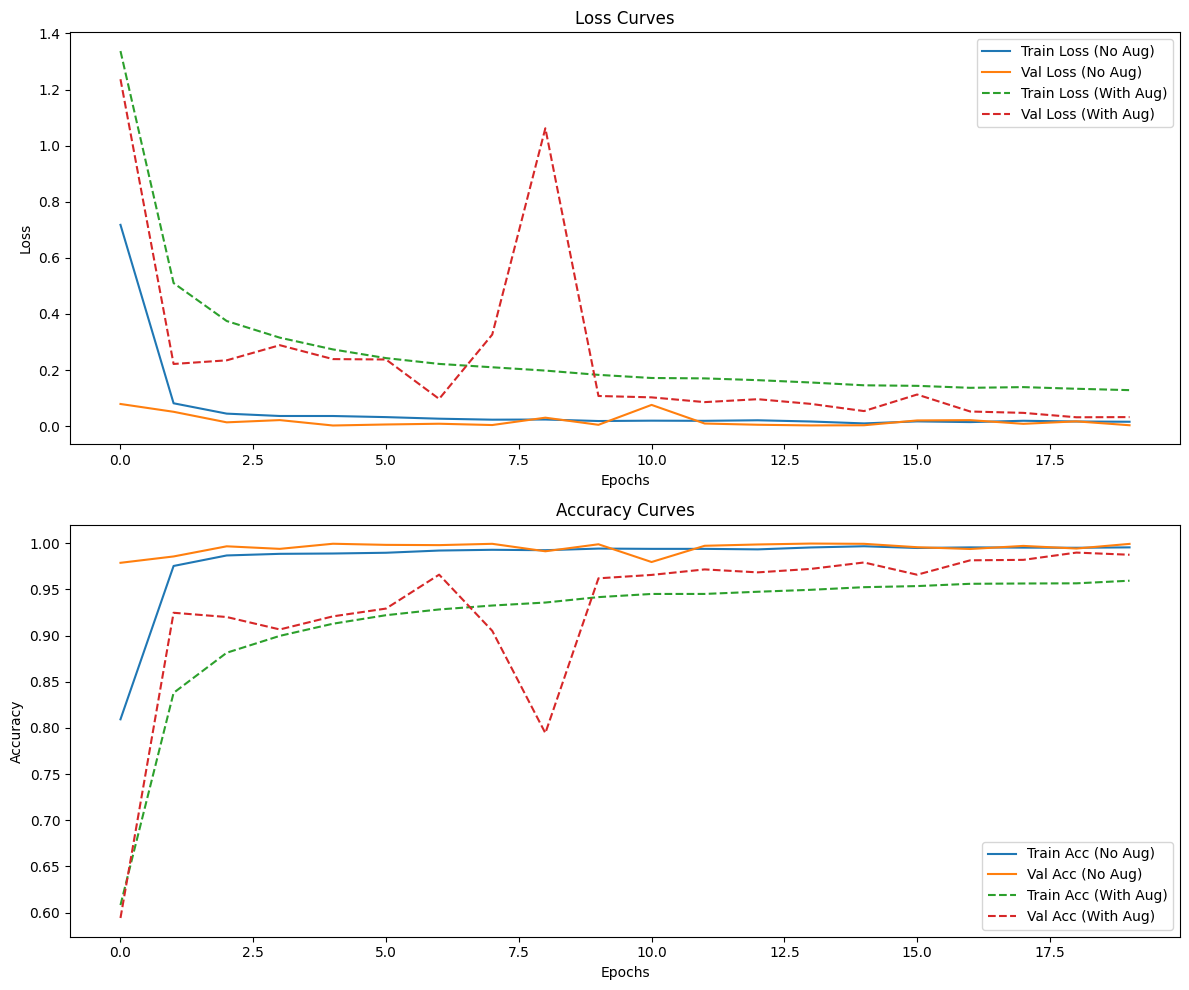

In [ ]:
plt.figure(figsize=(12, 10))

# Loss comparison
plt.subplot(2, 1, 1)
plt.plot(train_losses_no_aug_fruits, label='Train Loss (No Aug)')
plt.plot(val_losses_no_aug_fruits, label='Val Loss (No Aug)')
plt.plot(train_losses_aug_fruits, label='Train Loss (With Aug)', linestyle='dashed')
plt.plot(val_losses_aug_fruits, label='Val Loss (With Aug)', linestyle='dashed')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy comparison
plt.subplot(2, 1, 2)
plt.plot(train_accs_no_aug_fruits, label='Train Acc (No Aug)')
plt.plot(val_accs_no_aug_fruits, label='Val Acc (No Aug)')
plt.plot(train_accs_aug_fruits, label='Train Acc (With Aug)', linestyle='dashed')
plt.plot(val_accs_aug_fruits, label='Val Acc (With Aug)', linestyle='dashed')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Classification Report (No Aug):
                       precision    recall  f1-score   support

              Apple 6       1.00      1.00      1.00       157
     Apple Braeburn 1       0.90      0.98      0.94       164
 Apple Crimson Snow 1       1.00      0.97      0.99       148
       Apple Golden 1       1.00      1.00      1.00       160
       Apple Golden 2       1.00      1.00      1.00       164
       Apple Golden 3       0.96      1.00      0.98       161
 Apple Granny Smith 1       1.00      0.96      0.98       164
    Apple Pink Lady 1       0.97      1.00      0.99       152
          Apple Red 1       1.00      1.00      1.00       164
          Apple Red 2       0.98      1.00      0.99       164
          Apple Red 3       1.00      1.00      1.00       144
Apple Red Delicious 1       1.00      1.00      1.00       166
   Apple Red Yellow 1       1.00      0.90      0.95       164
   Apple Red Yellow 2       1.00      1.00      1.00       219
          Apple hit 1 

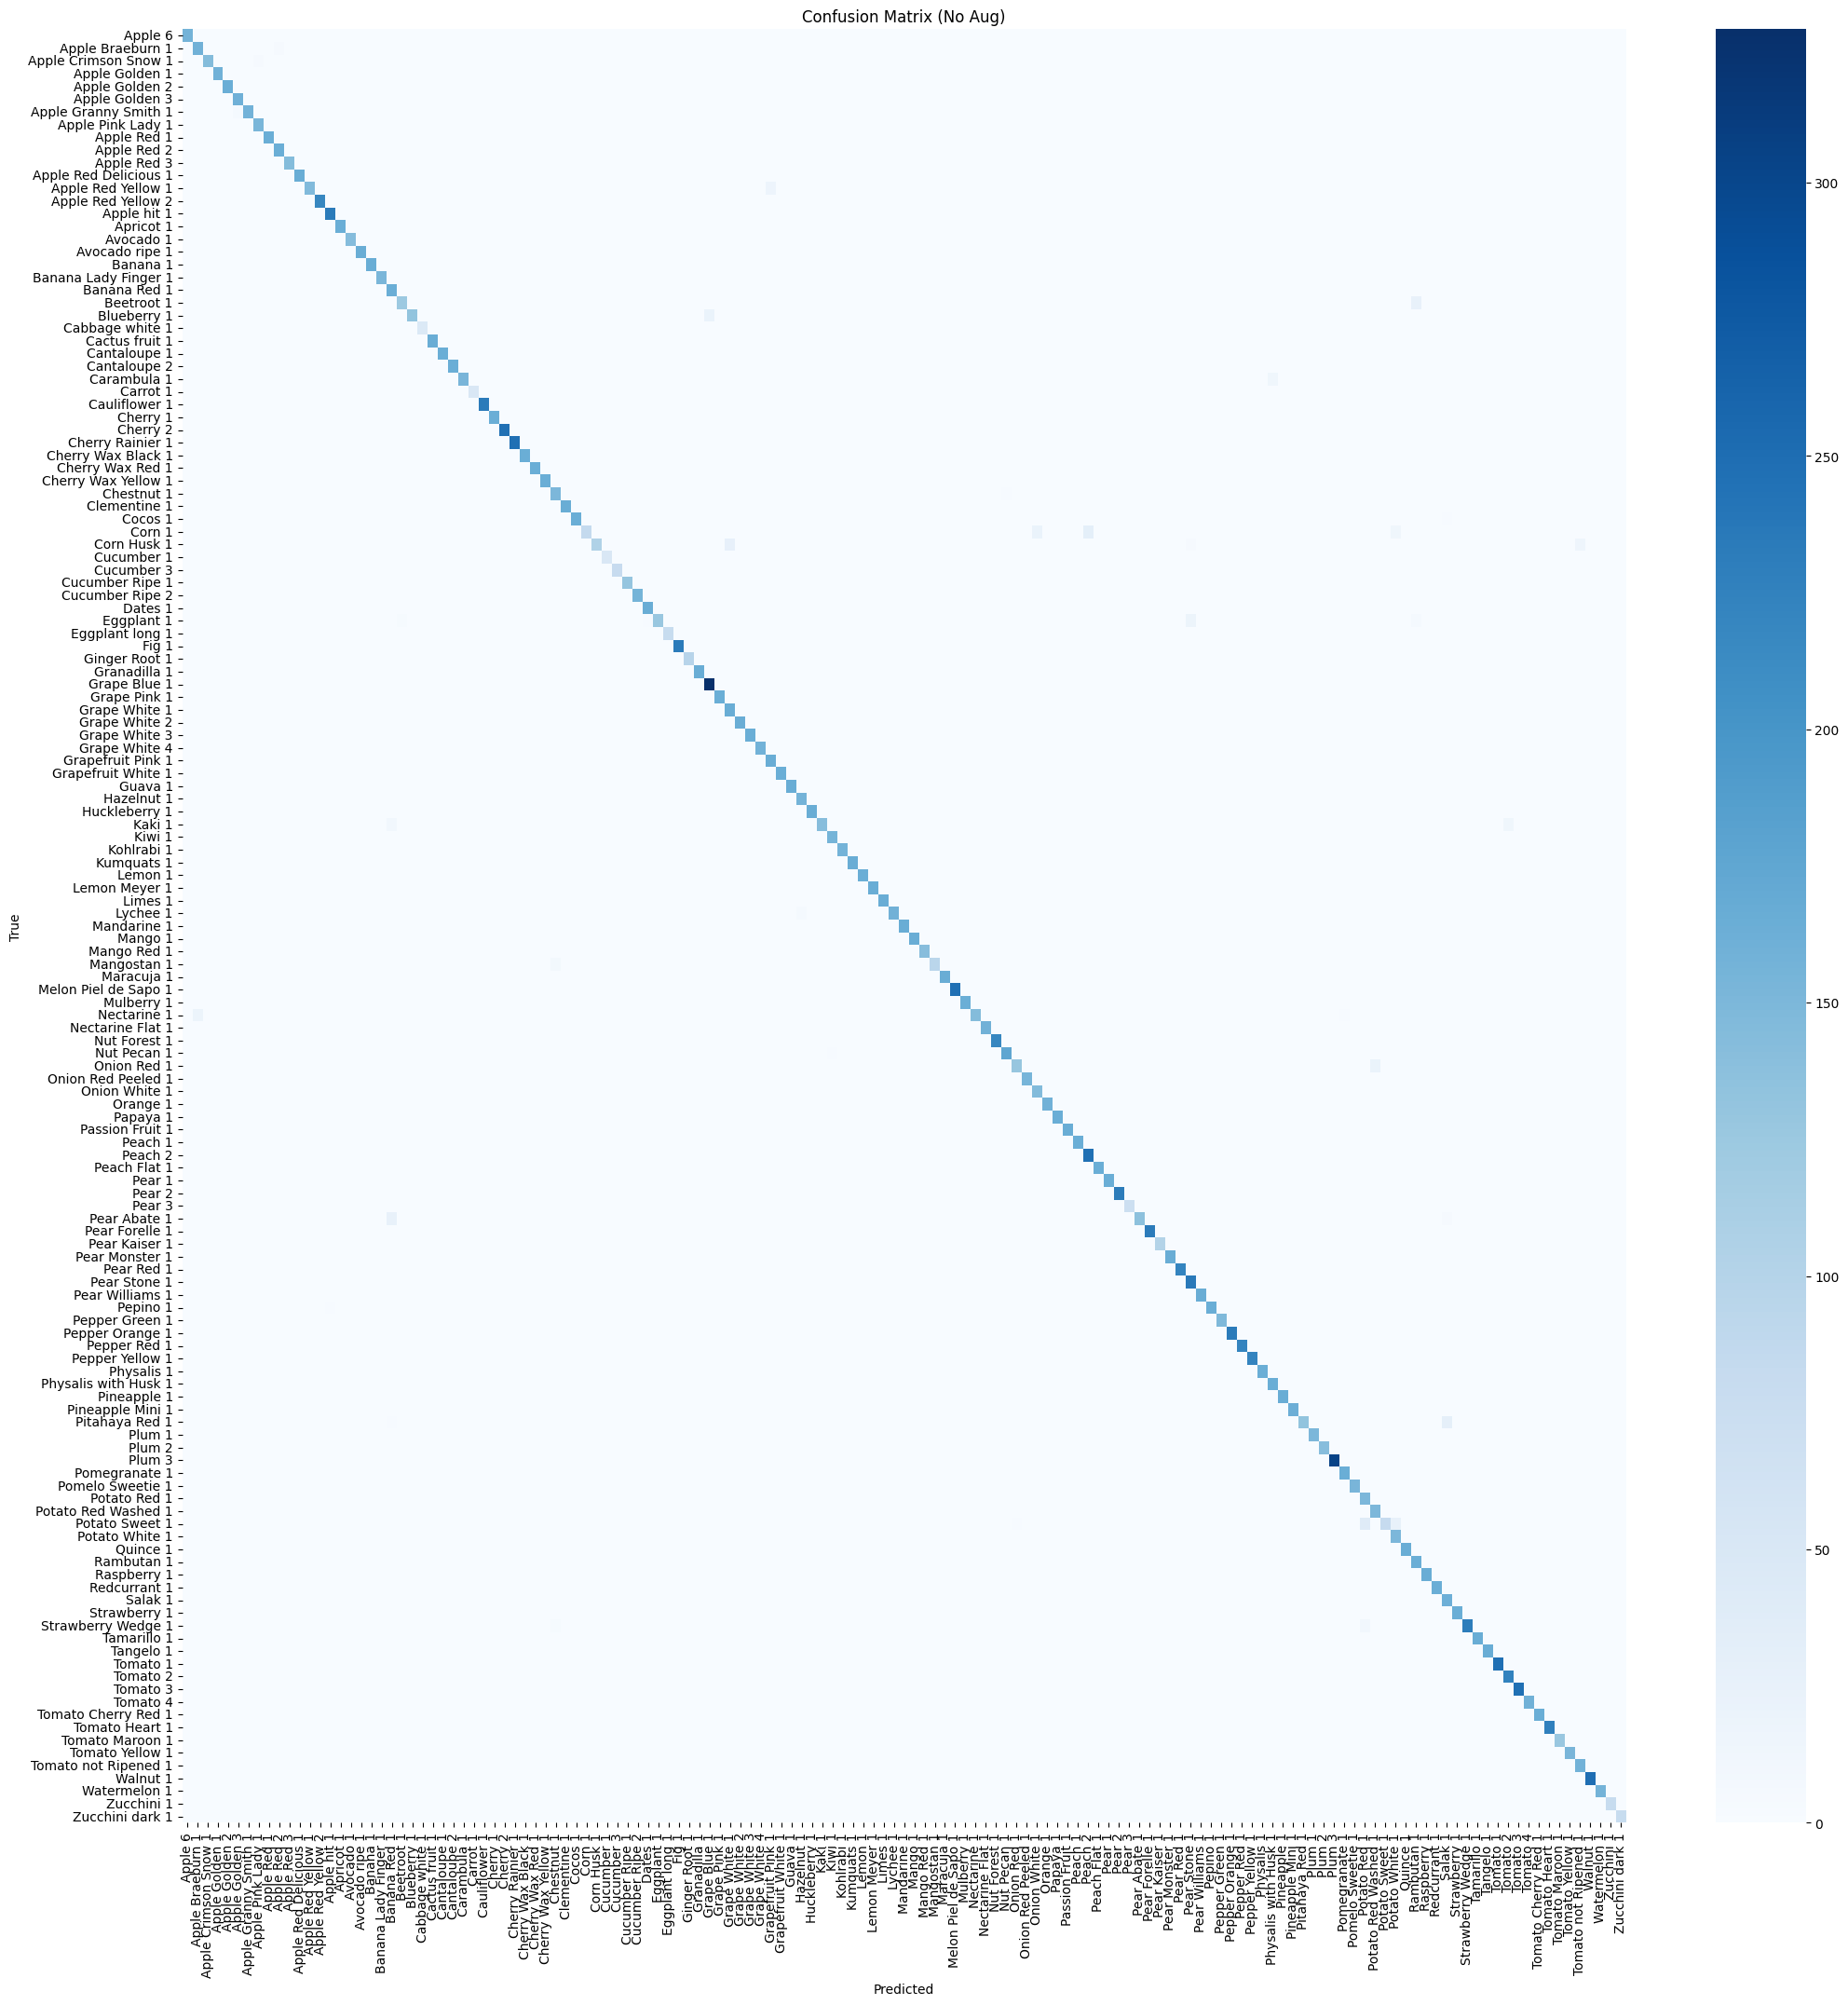

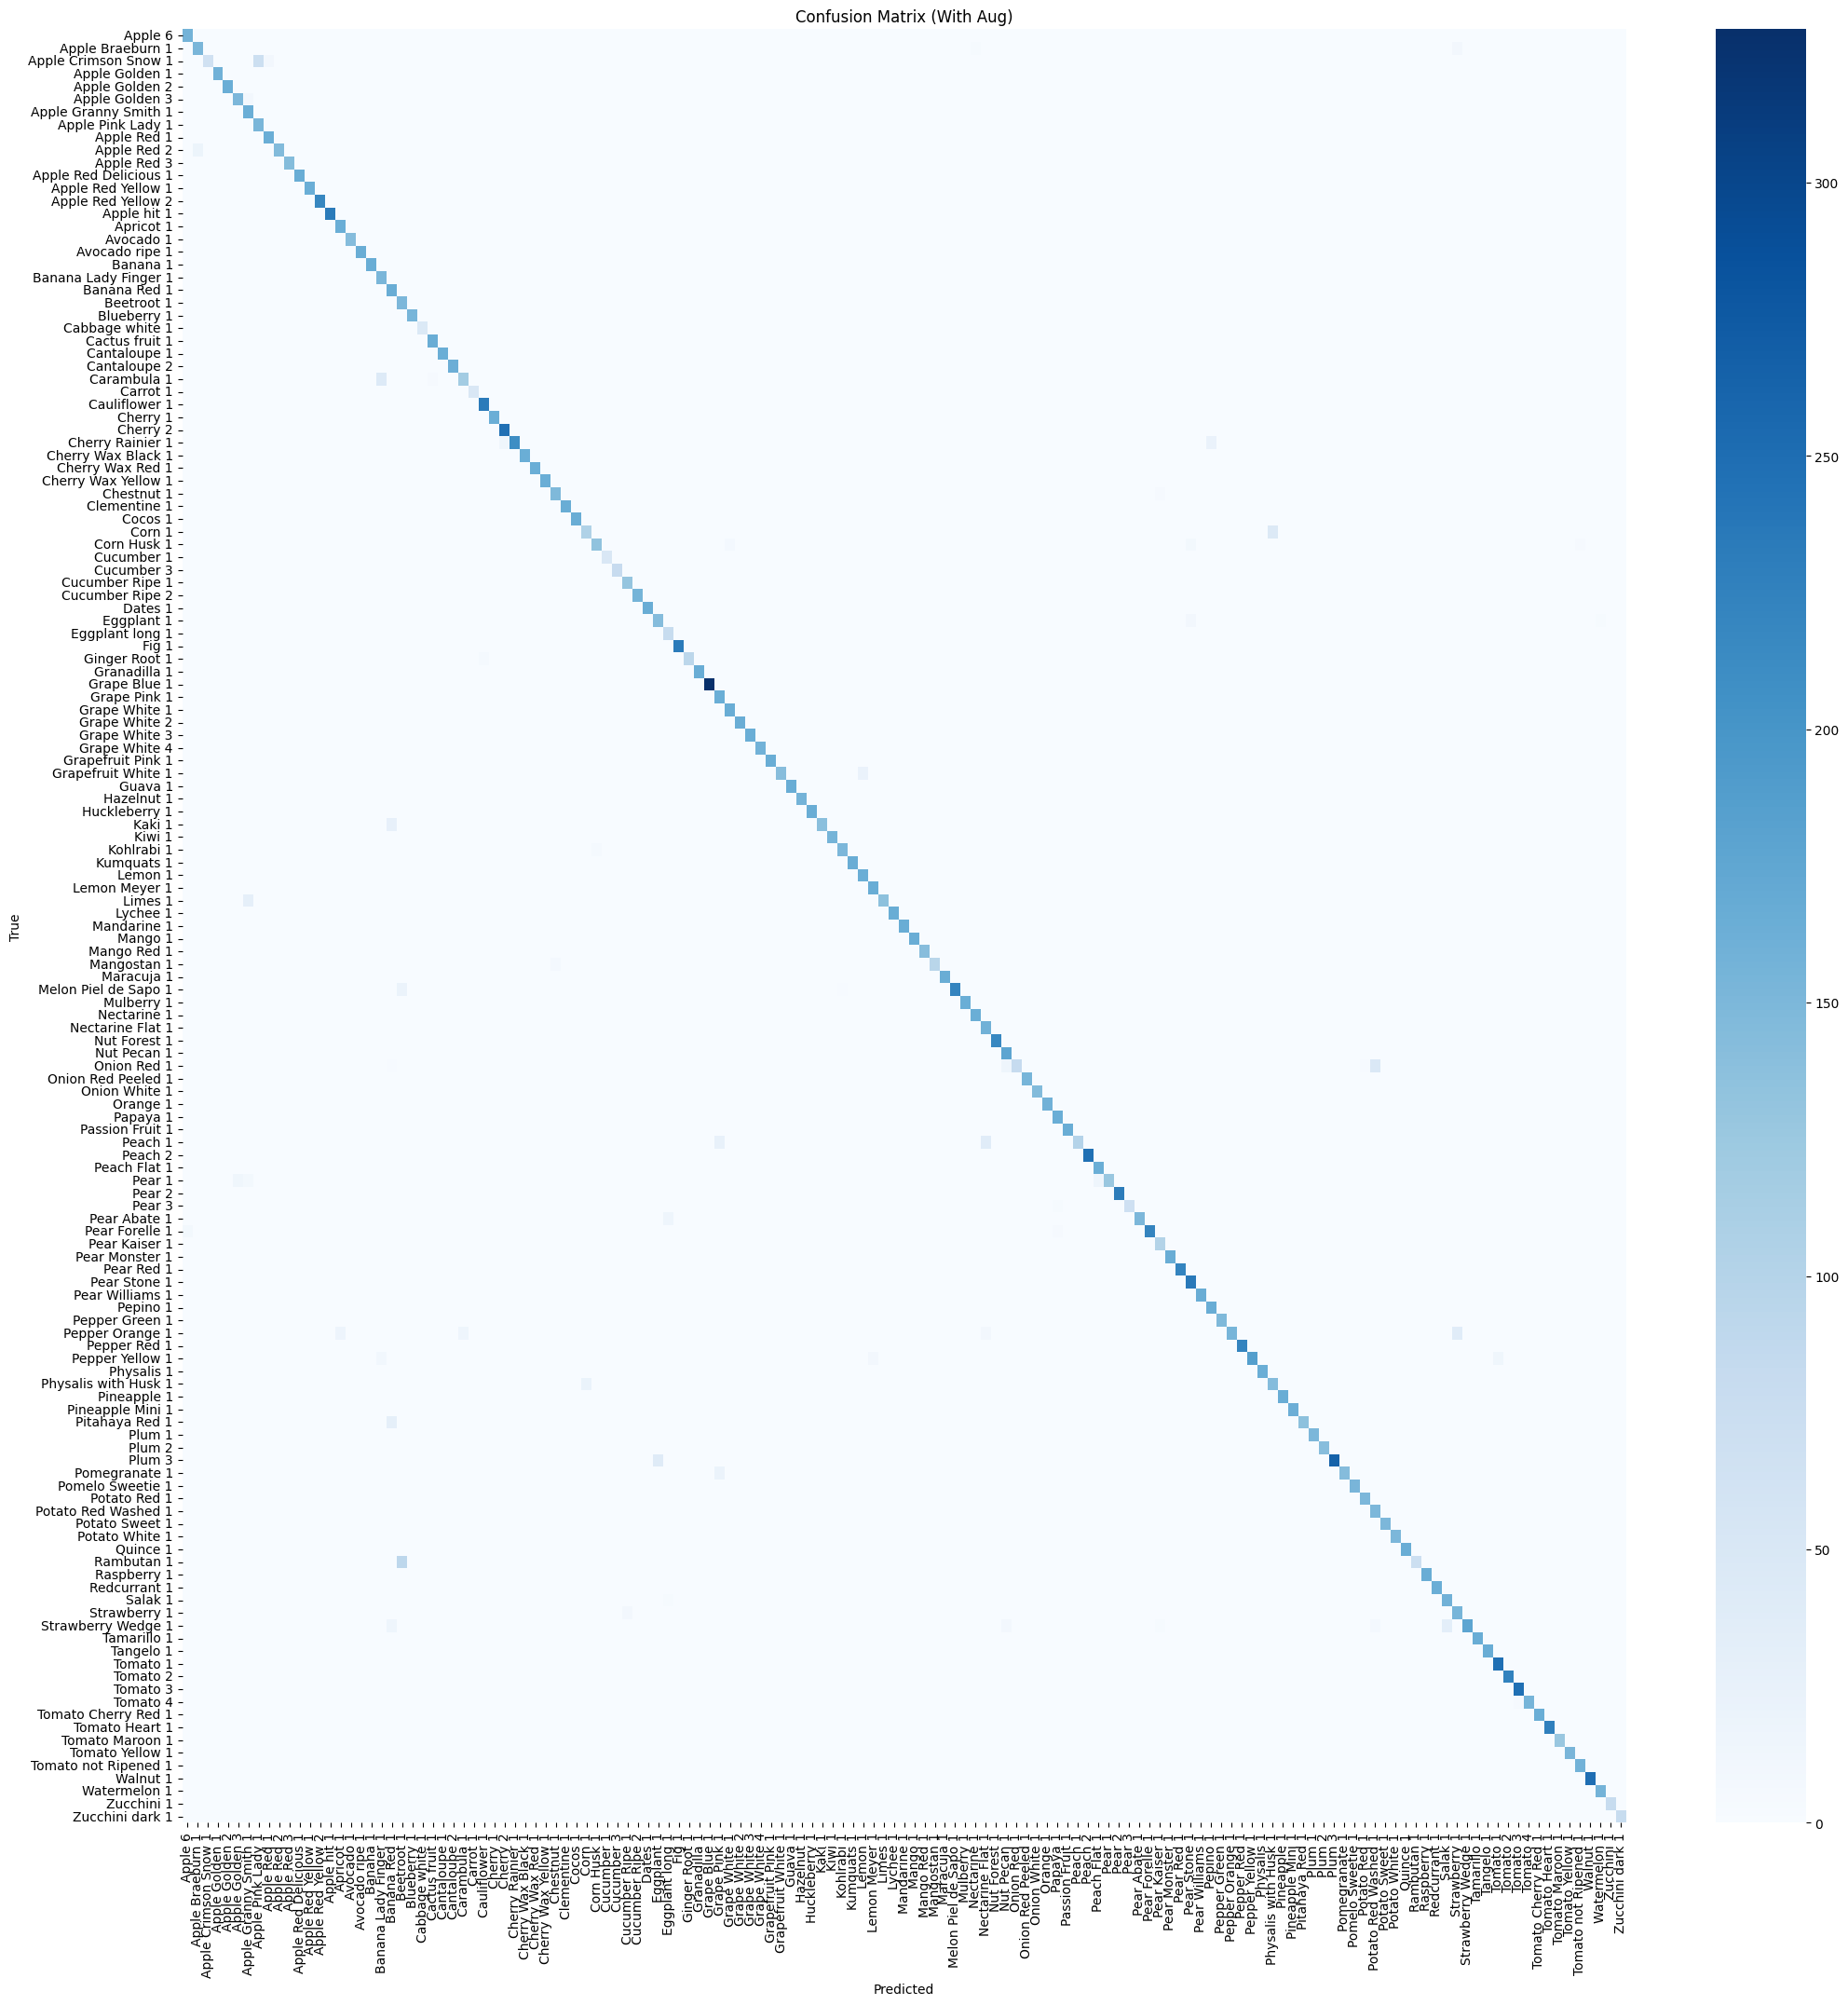

In [ ]:
def evaluate_model(model, loader, device):
	model.eval()
	all_preds, all_targets = [], []
	with torch.no_grad():
		for inputs, targets in loader:
			inputs, targets = inputs.to(device), targets.to(device)
			outputs = model(inputs)
			_, predicted = outputs.max(1)
			all_preds.extend(predicted.cpu().numpy())
			all_targets.extend(targets.cpu().numpy())
	return np.array(all_preds), np.array(all_targets)

# Evaluate both models
y_pred_no_aug_fruits, y_true_fruits = evaluate_model(model_no_aug_fruits, fruits_test_loader, device)
y_pred_aug_fruits, _ = evaluate_model(model_aug_fruits, fruits_test_loader, device)

# Classification reports
print("Classification Report (No Aug):")
print(classification_report(y_true_fruits, y_pred_no_aug_fruits, target_names=label_map_train.values()))

print("Classification Report (With Aug):")
print(classification_report(y_true_fruits, y_pred_aug_fruits, target_names=label_map_train.values()))

# Confusion matrix for No Aug
cm_no_aug_fruits = confusion_matrix(y_true_fruits, y_pred_no_aug_fruits)
plt.figure(figsize=(25, 25))
sns.heatmap(cm_no_aug_fruits, annot=False, fmt='d', cmap='Blues', xticklabels=label_map_train.values(), yticklabels=label_map_train.values())
plt.xticks(rotation=90)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (No Aug)')
plt.show()

# Confusion matrix for With Aug
cm_aug_fruits = confusion_matrix(y_true_fruits, y_pred_aug_fruits)
plt.figure(figsize=(25, 25))
sns.heatmap(cm_aug_fruits, annot=False, fmt='d', cmap='Blues', xticklabels=label_map_train.values(), yticklabels=label_map_train.values())
plt.xticks(rotation=90)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (With Aug)')
plt.show()

## ResNet

### Fashion

In [15]:
# Load Fashion-MNIST
def load_fashion_mnist():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = np.expand_dims(x_train / 255.0, axis=-1)  # Normalize and add channel
    x_test = np.expand_dims(x_test / 255.0, axis=-1)
    x_train = np.repeat(x_train, 3, axis=-1)  # Convert to 3 channels
    x_test = np.repeat(x_test, 3, axis=-1)

    return torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2), \
           torch.tensor(y_train, dtype=torch.long), \
           torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2), \
           torch.tensor(y_test, dtype=torch.long)

x_train_fashion, y_train_fashion, x_test_fashion, y_test_fashion = load_fashion_mnist()

# Data transformations
transform_fashion = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2471, 0.2435, 0.2616])

# Apply transformations
x_train_fashion = transform_fashion(x_train_fashion)
x_test_fashion = transform_fashion(x_test_fashion)

# Split training data for validation
fashion_dataset = TensorDataset(x_train_fashion, y_train_fashion)
train_size = int(0.8 * len(fashion_dataset))
val_size = len(fashion_dataset) - train_size
fashion_train_dataset, fashion_val_dataset = random_split(fashion_dataset, [train_size, val_size])

fashion_train_loader = DataLoader(fashion_train_dataset, batch_size=64, shuffle=True)
fashion_val_loader = DataLoader(fashion_val_dataset, batch_size=64, shuffle=False)
fashion_test_loader = DataLoader(TensorDataset(x_test_fashion, y_test_fashion), batch_size=64, shuffle=False)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [16]:
# Define the model
resnet_fashion = resnet18(pretrained=True, progress=True).to(device)
resnet_fashion.fc = nn.Linear(resnet_fashion.fc.in_features, 10)  # Adjust for Fashion-MNIST

# Optimizers and loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_fashion.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)  # Common SGD settings

/content/cifar10_models/resnet.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [17]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.to(device)
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return running_loss / len(loader), correct / total

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return running_loss / len(loader), correct / total

def train_and_validate(model, train_loader, val_loader, optimizer, criterion, device, num_epochs, dataset_name):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs

# Train
fashion_train_losses, fashion_val_losses, fashion_train_accs, fashion_val_accs = train_and_validate(
    resnet_fashion, fashion_train_loader, fashion_val_loader, optimizer, criterion, device, 20, "Fashion-MNIST"
)

# Evaluate on test set
test_loss, test_acc = validate_epoch(resnet_fashion, fashion_test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1: Train Loss=0.4367, Train Acc=0.8493, Val Loss=0.2766, Val Acc=0.9007
Epoch 2: Train Loss=0.2676, Train Acc=0.9044, Val Loss=0.2340, Val Acc=0.9153
Epoch 3: Train Loss=0.2255, Train Acc=0.9190, Val Loss=0.2483, Val Acc=0.9123
Epoch 4: Train Loss=0.1980, Train Acc=0.9286, Val Loss=0.2434, Val Acc=0.9117
Epoch 5: Train Loss=0.1761, Train Acc=0.9359, Val Loss=0.2119, Val Acc=0.9228
Epoch 6: Train Loss=0.1577, Train Acc=0.9430, Val Loss=0.2112, Val Acc=0.9253
Epoch 7: Train Loss=0.1400, Train Acc=0.9484, Val Loss=0.2050, Val Acc=0.9293
Epoch 8: Train Loss=0.1276, Train Acc=0.9534, Val Loss=0.2152, Val Acc=0.9242
Epoch 9: Train Loss=0.1124, Train Acc=0.9592, Val Loss=0.2203, Val Acc=0.9250
Epoch 10: Train Loss=0.0998, Train Acc=0.9642, Val Loss=0.2448, Val Acc=0.9201
Epoch 11: Train Loss=0.0942, Train Acc=0.9661, Val Loss=0.2359, Val Acc=0.9258
Epoch 12: Train Loss=0.0817, Train Acc=0.9704, Val Loss=0.2223, Val Acc=0.9286
Epoch 13: Train Loss=0.0777, Train Acc=0.9724, Val Loss=0.225

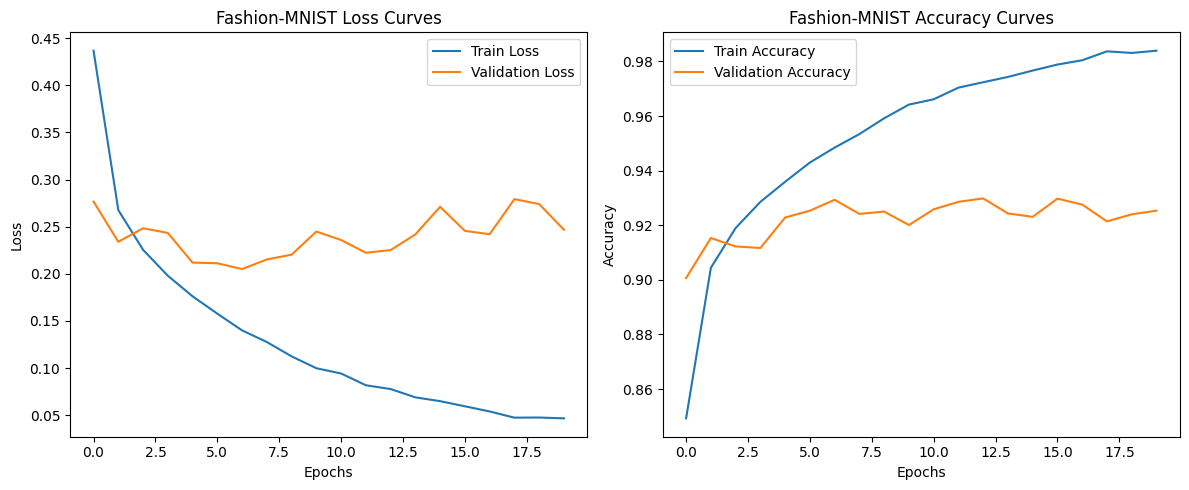

In [18]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs, dataset_name):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{dataset_name} Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title(f'{dataset_name} Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(fashion_train_losses, fashion_val_losses, fashion_train_accs, fashion_val_accs, "Fashion-MNIST")

Classification Report (Fashion-MNIST):
              precision    recall  f1-score   support

 T-shirt/top       0.89      0.86      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.88      0.88      0.88      1000
       Dress       0.93      0.92      0.93      1000
        Coat       0.88      0.89      0.88      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.76      0.78      0.77      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.98      0.99      0.98      1000
  Ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



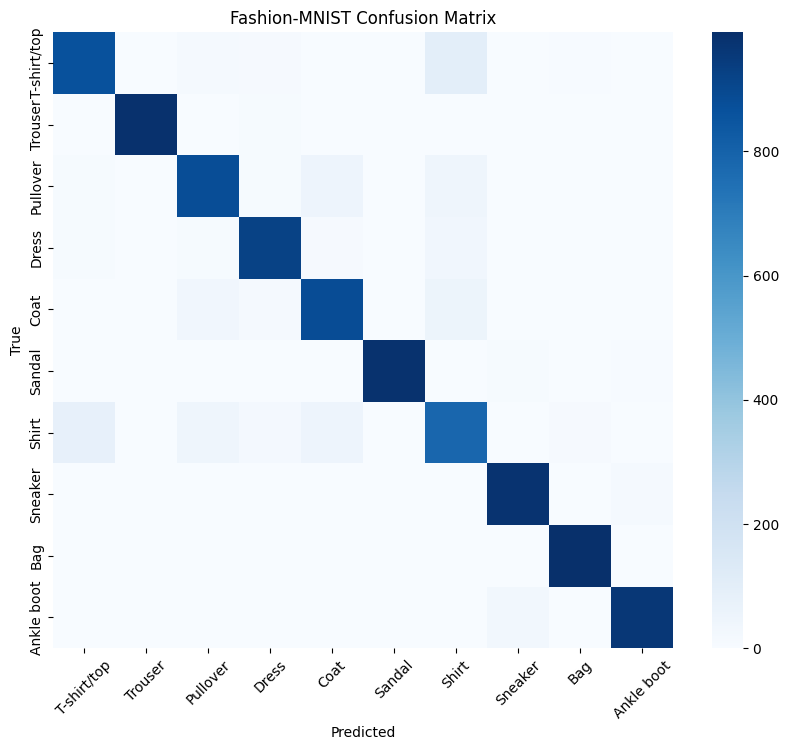

In [20]:
def evaluate_model(model, loader, device):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return np.array(all_preds), np.array(all_targets)

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

def plot_confusion_matrix(y_true, y_pred, class_names, dataset_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.show()

y_pred_fashion, y_true_fashion = evaluate_model(resnet_fashion, fashion_test_loader, device)
print("Classification Report (Fashion-MNIST):")
print(classification_report(y_true_fashion, y_pred_fashion, target_names=class_names))
plot_confusion_matrix(y_true_fashion, y_pred_fashion, class_names, "Fashion-MNIST")

### Fruit

In [4]:
# Downloading the dataset using kagglehub
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

# Defining the full paths for Training and Testing directories
train_dir = os.path.join(path, 'fruits-360_dataset_100x100/fruits-360/Training')
test_dir = os.path.join(path, 'fruits-360_dataset_100x100/fruits-360/Test')

def load_fruits_from_directory(directory, image_size=(32, 32)):
    images = []
    labels = []
    label_map = {}
    label = 0

    for fruit in os.listdir(directory):
        fruit_path = os.path.join(directory, fruit)
        if os.path.isdir(fruit_path):
            label_map[label] = fruit
            for image_file in os.listdir(fruit_path):
                image_path = os.path.join(fruit_path, image_file)
                image = Image.open(image_path)
                image = image.resize(image_size)
                image = np.array(image)

                images.append(image)
                labels.append(label)
            label += 1

    images = np.array(images)
    labels = np.array(labels)
    return torch.tensor(np.array(images), dtype=torch.float32).permute(0, 3, 1, 2), \
        torch.tensor(np.array(labels), dtype=torch.long), label_map

x_train_fruits, y_train_fruits, label_map_train = load_fruits_from_directory(train_dir)
x_test_fruits, y_test_fruits, _ = load_fruits_from_directory(test_dir)

# Normalize images
transform_fruits = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2471, 0.2435, 0.2616])
x_train_fruits = transform_fruits(x_train_fruits)
x_test_fruits = transform_fruits(x_test_fruits)

# Split training data for validation
fruits_dataset = TensorDataset(x_train_fruits, y_train_fruits)
train_size = int(0.8 * len(fruits_dataset))
val_size = len(fruits_dataset) - train_size
fruits_train_dataset, fruits_val_dataset = random_split(fruits_dataset, [train_size, val_size])

fruits_train_loader = DataLoader(fruits_train_dataset, batch_size=64, shuffle=True)
fruits_val_loader = DataLoader(fruits_val_dataset, batch_size=64, shuffle=False)
fruits_test_loader = DataLoader(TensorDataset(x_test_fruits, y_test_fruits), batch_size=64, shuffle=False)

100%|██████████| 964M/964M [00:43<00:00, 23.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/moltean/fruits/versions/11


In [5]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.to(device)
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return running_loss / len(loader), correct / total

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return running_loss / len(loader), correct / total

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
resnet_fruits = resnet18(pretrained=True).to(device)
resnet_fruits.fc = nn.Linear(resnet_fruits.fc.in_features, len(label_map_train))  # Adjust for 141 classes

# Use SGD optimizer
optimizer = optim.SGD(resnet_fruits.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)  # Common SGD settings
criterion = nn.CrossEntropyLoss()

# Train and validate the model
num_epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(resnet_fruits, fruits_train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(resnet_fruits, fruits_val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

# Evaluate on test set
test_loss, test_acc = validate_epoch(resnet_fruits, fruits_test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

/content/cifar10_models/resnet.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


Epoch 1: Train Loss=1.2792, Train Acc=0.7169, Val Loss=0.2520, Val Acc=0.9346
Epoch 2: Train Loss=0.0609, Train Acc=0.9888, Val Loss=0.1248, Val Acc=0.9685
Epoch 3: Train Loss=0.0293, Train Acc=0.9948, Val Loss=0.0044, Val Acc=0.9996
Epoch 4: Train Loss=0.0128, Train Acc=0.9984, Val Loss=0.0041, Val Acc=0.9997
Epoch 5: Train Loss=0.0070, Train Acc=0.9996, Val Loss=0.0029, Val Acc=0.9999
Epoch 6: Train Loss=0.0113, Train Acc=0.9987, Val Loss=0.0050, Val Acc=0.9995
Epoch 7: Train Loss=0.0163, Train Acc=0.9976, Val Loss=0.0022, Val Acc=0.9999
Epoch 8: Train Loss=0.0077, Train Acc=0.9992, Val Loss=0.0049, Val Acc=0.9996
Epoch 9: Train Loss=0.0187, Train Acc=0.9971, Val Loss=0.0247, Val Acc=0.9935
Epoch 10: Train Loss=0.0119, Train Acc=0.9986, Val Loss=0.0287, Val Acc=0.9930
Epoch 11: Train Loss=0.0141, Train Acc=0.9985, Val Loss=0.0346, Val Acc=0.9918
Epoch 12: Train Loss=0.0218, Train Acc=0.9966, Val Loss=0.0103, Val Acc=0.9961
Epoch 13: Train Loss=0.0162, Train Acc=0.9974, Val Loss=0.002

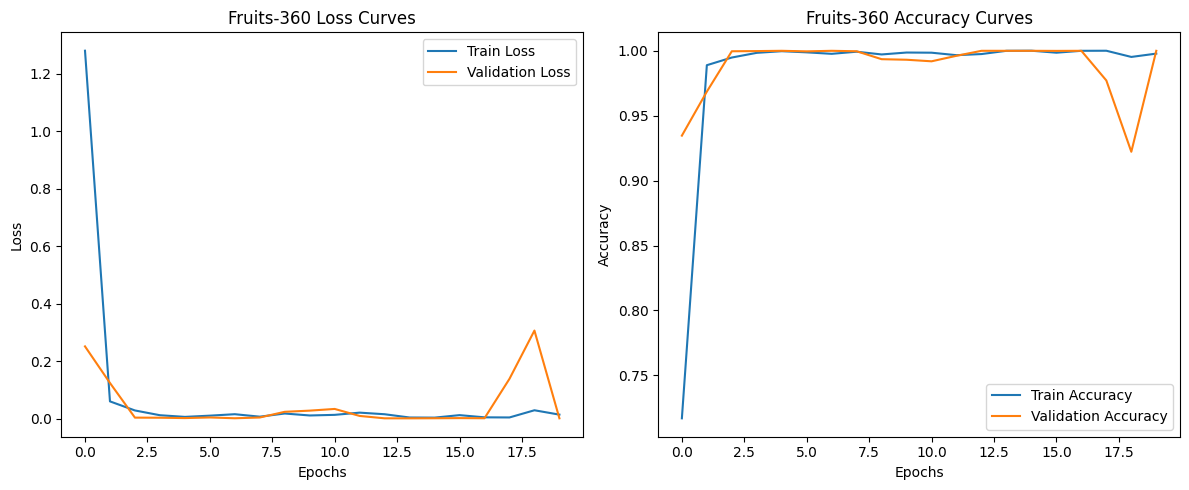

In [13]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Fruits-360 Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Fruits-360 Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(train_losses, val_losses, train_accs, val_accs)

Classification Report (Fruits-360):
                       precision    recall  f1-score   support

              Apple 6       1.00      1.00      1.00        80
     Apple Braeburn 1       1.00      1.00      1.00       166
 Apple Crimson Snow 1       1.00      1.00      1.00       166
       Apple Golden 1       1.00      1.00      1.00       246
       Apple Golden 2       1.00      1.00      1.00       164
       Apple Golden 3       0.99      1.00      1.00       154
 Apple Granny Smith 1       0.98      1.00      0.99       164
    Apple Pink Lady 1       1.00      1.00      1.00       164
          Apple Red 1       1.00      1.00      1.00       157
          Apple Red 2       1.00      1.00      1.00       234
          Apple Red 3       1.00      1.00      1.00       164
Apple Red Delicious 1       0.94      1.00      0.97       157
   Apple Red Yellow 1       1.00      0.79      0.88       154
   Apple Red Yellow 2       1.00      1.00      1.00       144
          Apple hi

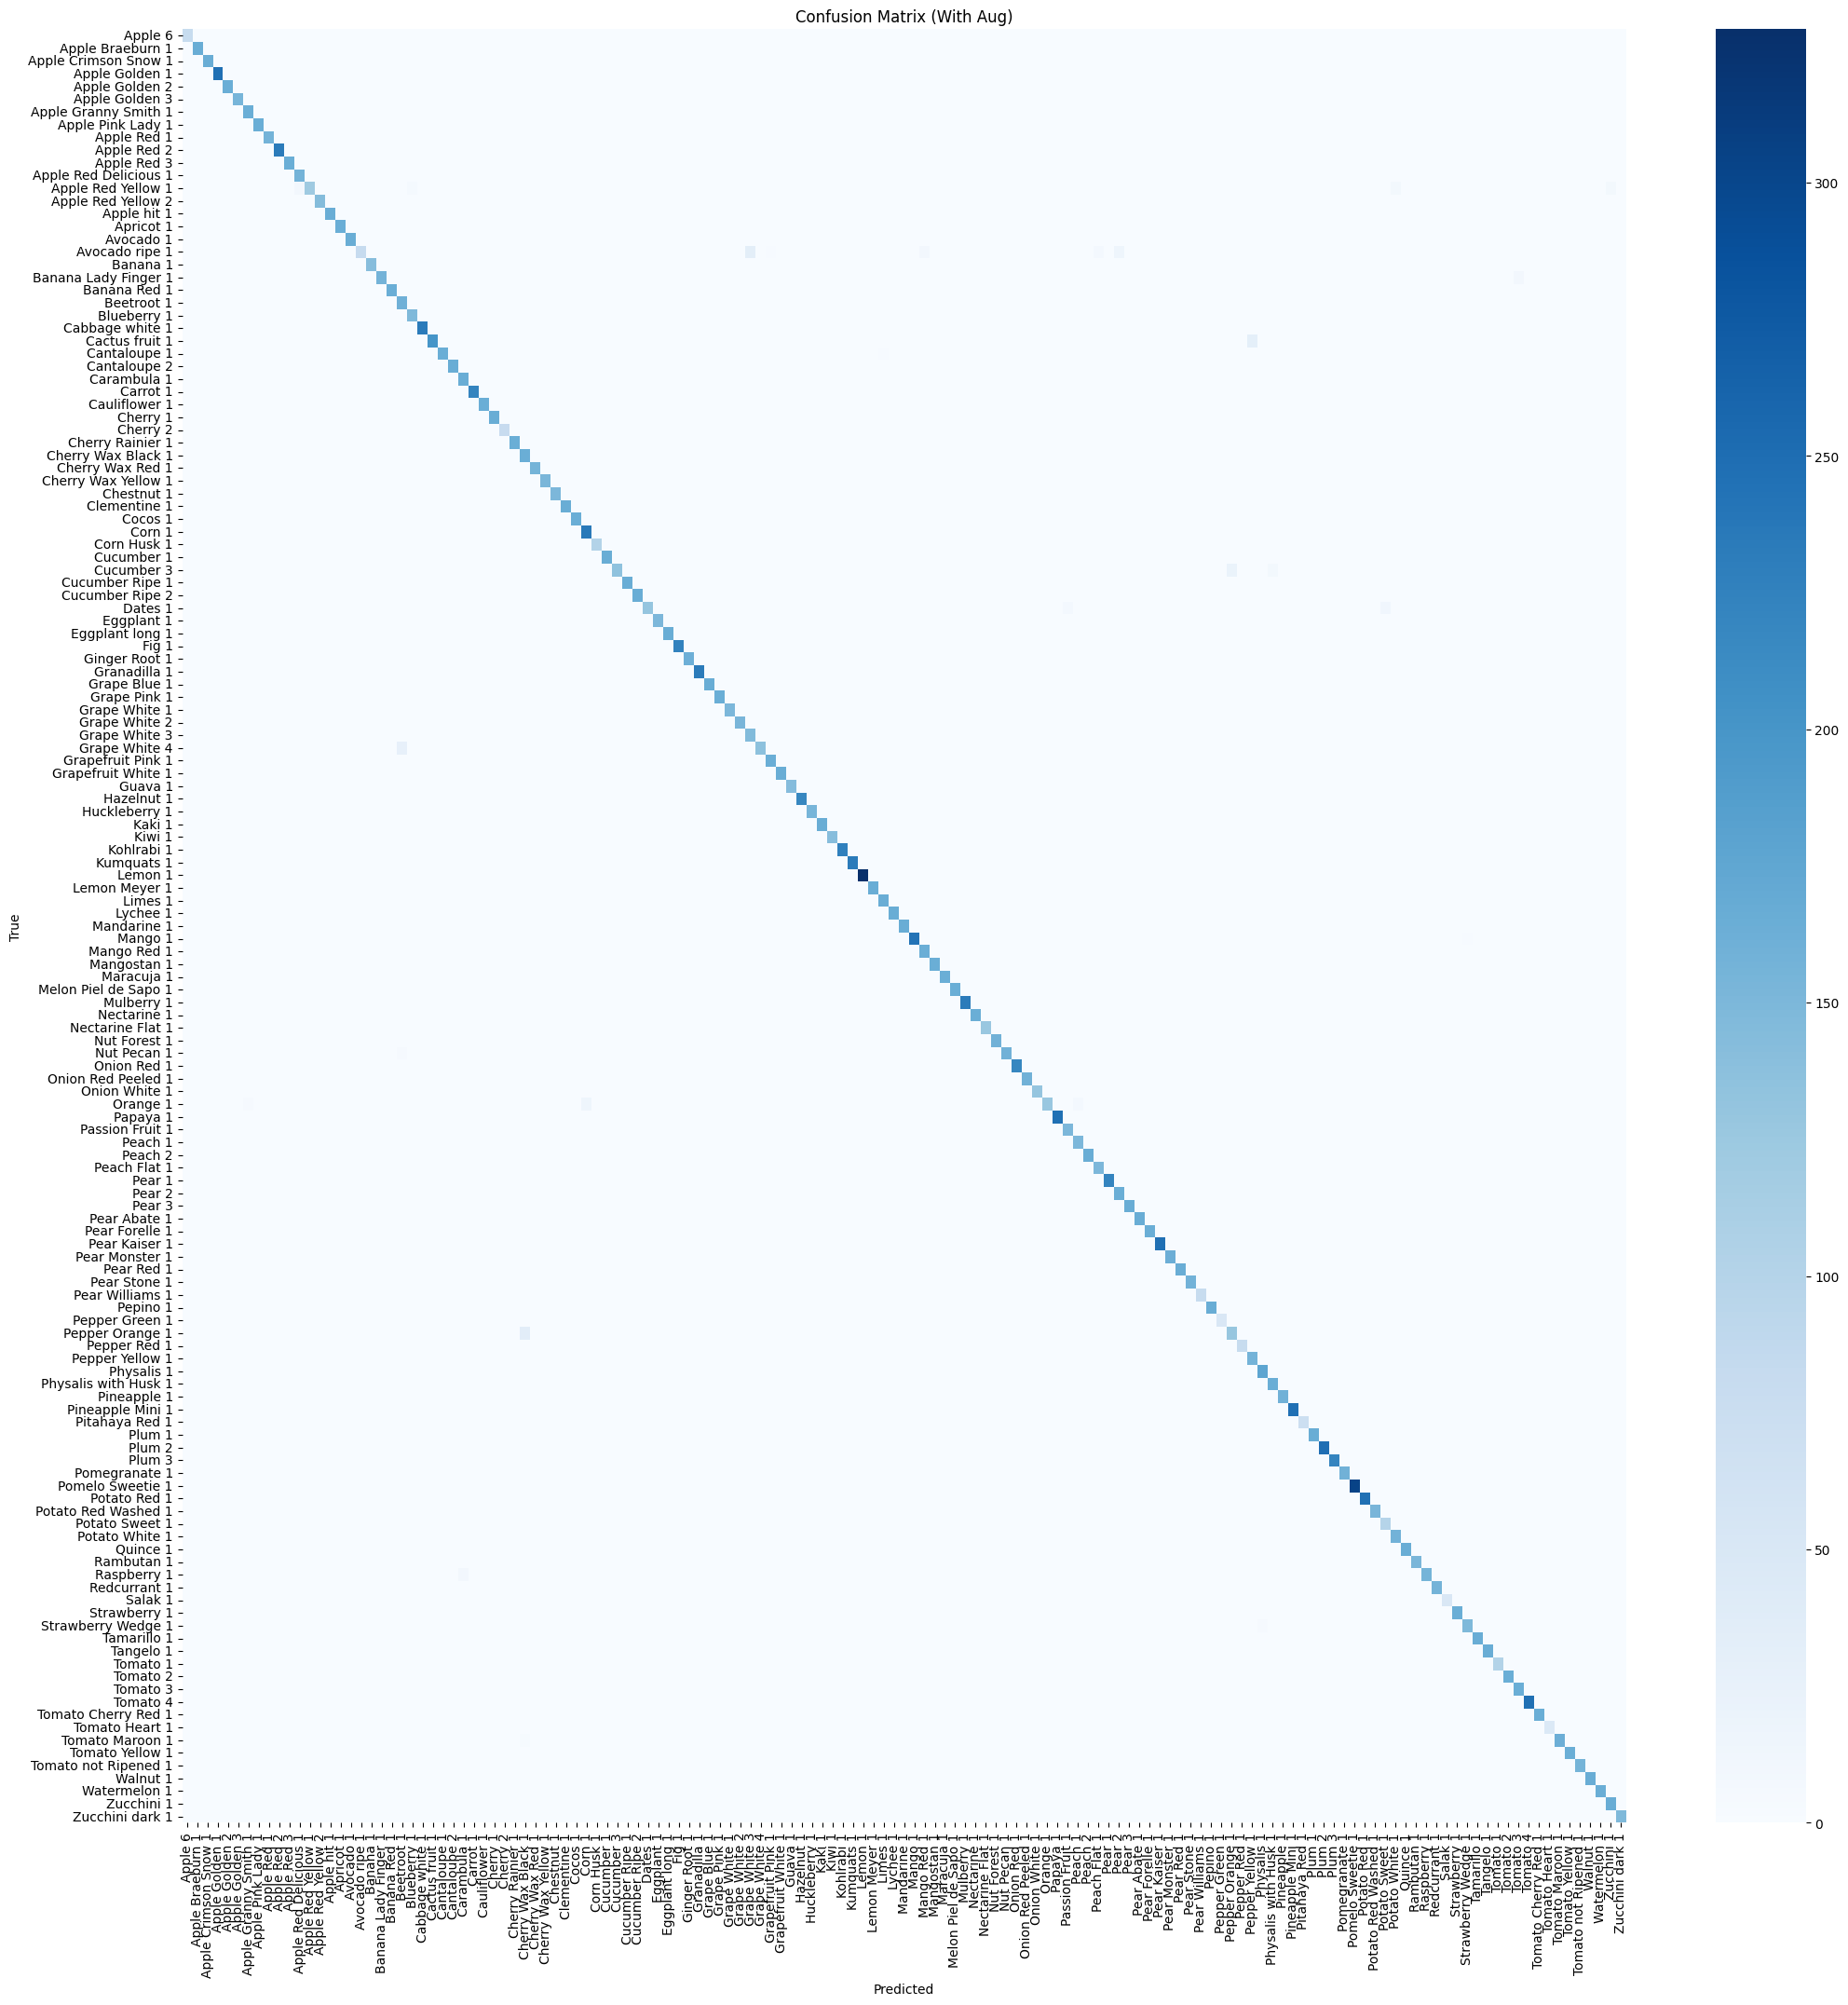

In [22]:
def evaluate_model(model, loader, device):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return np.array(all_preds), np.array(all_targets)

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(25, 25))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xticks(rotation=90)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (With Aug)')
    plt.show()

# Evaluate on test set
y_pred_fruits, y_true_fruits = evaluate_model(resnet_fruits, fruits_test_loader, device)
print("Classification Report (Fruits-360):")
print(classification_report(y_true_fruits, y_pred_fruits, target_names=sorted(label_map_train.values())))

plot_confusion_matrix(y_true_fruits, y_pred_fruits, sorted(label_map_train.values()))